## Angular Response function for LISA


In [32]:
import numpy as np
import matplotlib.pyplot as plt


from nest import detectors
#from nest import pls
from nest import overlap 
from nest import nell 
from nest import skymap

from astropy.cosmology import Planck18

cosmo = Planck18
H0 =  cosmo.H0.to('1/s').value

In [2]:
L = 2.5e6 # [km]
c = 3e5 # [km/s]
f_star = c/2/np.pi/L # [Hz]

In [3]:
xA = np.array([0,0,0])
xB = np.array([+1/2, np.sqrt(3)/2, 0])
xC = np.array([-1/2, np.sqrt(3)/2, 0])
lBA = xB - xA
lCA = xC - xA
lBC = xB - xC

In [4]:
def e_plus(Theta_mesh,Phi_mesh):
    v = np.array([np.sin(Phi_mesh), -np.cos(Phi_mesh), np.zeros_like(Theta_mesh)])
    u = np.array([np.cos(Phi_mesh) * np.cos(Theta_mesh),np.sin(Phi_mesh) * np.cos(Theta_mesh),-np.sin(Theta_mesh)])
    return (np.einsum('i...,k...',u,u)-np.einsum('i...,k...',v,v))

def e_cross(Theta_mesh,Phi_mesh):
    v = np.array([np.sin(Phi_mesh), -np.cos(Phi_mesh), np.zeros_like(Theta_mesh)])
    u = np.array([np.cos(Phi_mesh) * np.cos(Theta_mesh),np.sin(Phi_mesh) * np.cos(Theta_mesh),-np.sin(Theta_mesh)])
    return (np.einsum('i...,k...',u,v)+np.einsum('i...,k...',v,u))

ortogonality condition.

In [5]:
Theta_vec = np.linspace(0,np.pi,100)
Phi_vec = np.linspace(0,2*np.pi,1)
Theta_mesh, Phi_mesh = np.meshgrid(Theta_vec, Phi_vec)
Omega = np.round(np.array([np.cos(Phi_mesh)*np.sin(Theta_mesh),np.sin(Phi_mesh)*np.sin(Theta_mesh),np.cos(Theta_mesh)]),20)
# Verify the orthogonality condition
print(np.einsum('lmij,lmij->lm',e_cross(Theta_mesh,Phi_mesh),e_cross(Theta_mesh,Phi_mesh)))
print(np.einsum('lmij,lmij->lm',e_plus(Theta_mesh,Phi_mesh),e_plus(Theta_mesh,Phi_mesh)))
print(np.einsum('lmij,lmij->lm',e_cross(Theta_mesh,Phi_mesh),e_plus(Theta_mesh,Phi_mesh)))

[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2.]]
[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]]


## LISA Response function



In [6]:
def Evaluate_Product(l_vec,Theta_mesh,Phi_mesh,tensor):
    if tensor == 'plus':
        e_values = e_plus(Theta_mesh,Phi_mesh)
    elif tensor == 'cross':
        e_values = e_cross(Theta_mesh,Phi_mesh)
    result = np.einsum('i,j,lmij', l_vec,l_vec, e_values) # [n_Phi, n_Theta]
    return result
    

Transfer function.
\begin{equation*}
\mathcal{T}(f,\hat{l}_{AB},\hat{n})=\frac{1}{2}\left[e^{ -\pi i f L (1+\hat{k}\cdot \hat{l}_{AB})} {\rm{sinc}}\left(f L (1+\hat{k}\cdot \hat{l}_{AB})\right)+ e^{ -\pi i f L (3+\hat{k}\cdot \hat{l}_{AB})} {\rm{sinc}}\left(f L (1-\hat{k}\cdot \hat{l}_{AB})\right)\right]
\end{equation*}



In [7]:
# Build the transfer function
def F_cal (l,Omega,f_vec,f_star):
    inner = np.einsum('i,ijk',l,Omega)
    return 1/2 * (  np.sinc(f_vec/2/np.pi/f_star * (1-inner)) * np.exp(-1j*f_vec/2/f_star * (3+inner))\
                                    + np.sinc(f_vec/2/np.pi/f_star * (1+inner)) * np.exp(-1j*f_vec/2/f_star * (1+inner)))

Check $\mathcal{T} (f\ll f_*) = 1$. 

In [8]:
f_vec_try = np.logspace(-5,-3,200)
print(np.real(F_cal(lBA,Omega,np.expand_dims(f_vec_try,axis=(1,2)),f_star)))

[[[0.99999982 0.99999982 0.99999981 ... 0.99999981 0.99999982 0.99999982]]

 [[0.99999981 0.99999981 0.9999998  ... 0.9999998  0.99999981 0.99999981]]

 [[0.9999998  0.9999998  0.99999979 ... 0.99999979 0.9999998  0.9999998 ]]

 ...

 [[0.99833472 0.9983148  0.9982947  ... 0.9982947  0.9983148  0.99833472]]

 [[0.99825587 0.99823501 0.99821396 ... 0.99821396 0.99823501 0.99825587]]

 [[0.9981733  0.99815145 0.9981294  ... 0.9981294  0.99815145 0.9981733 ]]]


### Step 3


\begin{equation*}
    \mathcal{R}_{AA'}(f) = \int \frac{d\Omega_{\vec {k}}}{4 \pi} \left[ \mathcal{R}_A^+(f,\hat{l}_{AB},\hat{l}_{AC},\hat{n}){\mathcal{R}_{A'}^+}^*(f,\hat{l}_{A'B'},\hat{l}_{A'C'},\hat{n}) + \mathcal{R}_A^{\times}(f,\hat{l}_{AB},\hat{l}_{AC},\hat{n}){\mathcal{R}_{A'}^{\times}}^*(f,\hat{l}_{A'B'},\hat{l}_{A'C'},\hat{n})\right]\,,
\end{equation*}
with
\begin{equation*}
\mathcal{R}_A^P(f,\hat{l}_{AB},\hat{l}_{AC},\hat{n}) = \frac{1}{2} e^{-i2\pi f \hat{n}\cdot\vec{x}_A/c} \left[\mathcal{T}(f,\hat{l}_{AB},\hat{n})-\mathcal{T}(f,\hat{l}_{AC},\hat{n})  \right]
\end{equation*}



In [9]:
def F_det (l1,l2,Theta_mesh,Phi_mesh,f_vec,f_star,x_det):
    Omega = np.round(np.array([np.cos(Phi_mesh)*np.sin(Theta_mesh),np.sin(Phi_mesh)*np.sin(Theta_mesh),np.cos(Theta_mesh)]),20)
    f_exp = np.expand_dims(f_vec, axis=(1,2))
    F_1 = F_cal(l1,Omega,f_exp,f_star)
    F_2 = F_cal(l2,Omega,f_exp,f_star)
    return 1/2 * np.exp(-1j* f_exp/f_star * np.einsum('i,ijk',x_det,Omega)) \
            * (+ F_1 * Evaluate_Product(l1,Theta_mesh,Phi_mesh,'plus')\
               - F_2 * Evaluate_Product(l2,Theta_mesh,Phi_mesh,'plus')),\
            1/2 * np.exp(-1j* f_exp/f_star * np.einsum('i,ijk',x_det,Omega)) \
            * (+ F_1 * Evaluate_Product(l1,Theta_mesh,Phi_mesh,'cross')\
               - F_2 * Evaluate_Product(l2,Theta_mesh,Phi_mesh,'cross')),

def Response(l_det1,l_det2,x_det1,x_det2,f_vec,f_star):
    Theta_vec = np.linspace(0,np.pi,100)
    Phi_vec = np.linspace(0,2*np.pi,100)
    Theta_mesh, Phi_mesh = np.meshgrid(Theta_vec, Phi_vec)
    F1_p, F1_c = F_det(l_det1[0],l_det1[1],Theta_mesh,Phi_mesh,f_vec,f_star,x_det1)
    F2_p, F2_c = F_det(l_det2[0],l_det2[1],Theta_mesh,Phi_mesh,f_vec,f_star,x_det2)
    R_integrand = F1_p  * np.conj(F2_p) \
                + F1_c * np.conj(F2_c)
    R1 = np.trapz(R_integrand,Phi_vec,axis=1)
    R = np.real(np.trapz(R1 * np.sin(Theta_vec),Theta_vec,axis=1))/4/np.pi
    return R

#tinto
#Saito

In [11]:
from scipy.special import sph_harm

def Ylm(l,m,theta,phi):
    return sph_harm(m,l,phi,theta)

def Response_ell(l_det1,l_det2,x_det1,x_det2,f_vec,f_star,ell,m):
    Theta_vec = np.linspace(0,np.pi,100)
    Phi_vec = np.linspace(0,2*np.pi,100)
    Theta_mesh, Phi_mesh = np.meshgrid(Theta_vec, Phi_vec)
    F1_p, F1_c = F_det(l_det1[0],l_det1[1],Theta_mesh,Phi_mesh,f_vec,f_star,x_det1)
    F2_p, F2_c = F_det(l_det2[0],l_det2[1],Theta_mesh,Phi_mesh,f_vec,f_star,x_det2)
    R_integrand_ell = (F1_p  * np.conj(F2_p) \
                + F1_c * np.conj(F2_c)) * Ylm(ell,m,Theta_mesh,Phi_mesh)*np.sqrt(4*np.pi)  #SPHERICAL HARMONIC redefined according to Eq. 4.2 paper LISA anisotropies
    R1 = np.trapz(R_integrand_ell,Phi_vec,axis=1)
    #Rellm = np.real(np.trapz(R1 * np.sin(Theta_vec),Theta_vec,axis=1))/4/np.pi
    Rellm = np.trapz(R1 * np.sin(Theta_vec),Theta_vec,axis=1)/4/np.pi
    return Rellm

In [12]:
# Verify the normalization
lA = (lBA,lCA)
lB = (-lBC,-lBA)
lC = (-lCA,lBC)
# R1 = Response(lA,lA,xA,xA,np.array([1e-5]),f_star)
# R2 = Response(lA,lB,xA,xB,np.array([1e-5]),f_star)

# print(R1/3*10)
# print(R2/(-3)*20)

f_vec = np.unique(np.concatenate((np.logspace(-5, -2, 10),np.linspace(1e-2,1e-1,60),np.linspace(1e-1, 1, 400))))

R1_vec = Response(lA,lA,xA,xA,f_vec,f_star)
R2_vec = Response(lA,lB,xA,xB,f_vec,f_star)

In [13]:
lA = (lBA,lCA)
lB = (-lBC,-lBA)
lC = (-lCA,lBC)
# R1 = Response(lA,lA,xA,xA,np.array([1e-5]),f_star)
# R2 = Response(lA,lB,xA,xB,np.array([1e-5]),f_star)

# print(R1/3*10)
# print(R2/(-3)*20)

f_vec = np.unique(np.concatenate((np.logspace(-5, -2, 10),np.linspace(1e-2,1e-1,60),np.linspace(1e-1, 1, 400))))

R1_vec_ell = Response_ell(lA,lA,xA,xA,f_vec,f_star, 0, 0)
R2_vec_ell = Response_ell(lA,lB,xA,xB,f_vec,f_star, 0, 0)

/opt/anaconda3/envs/ETcorr/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/envs/ETcorr/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


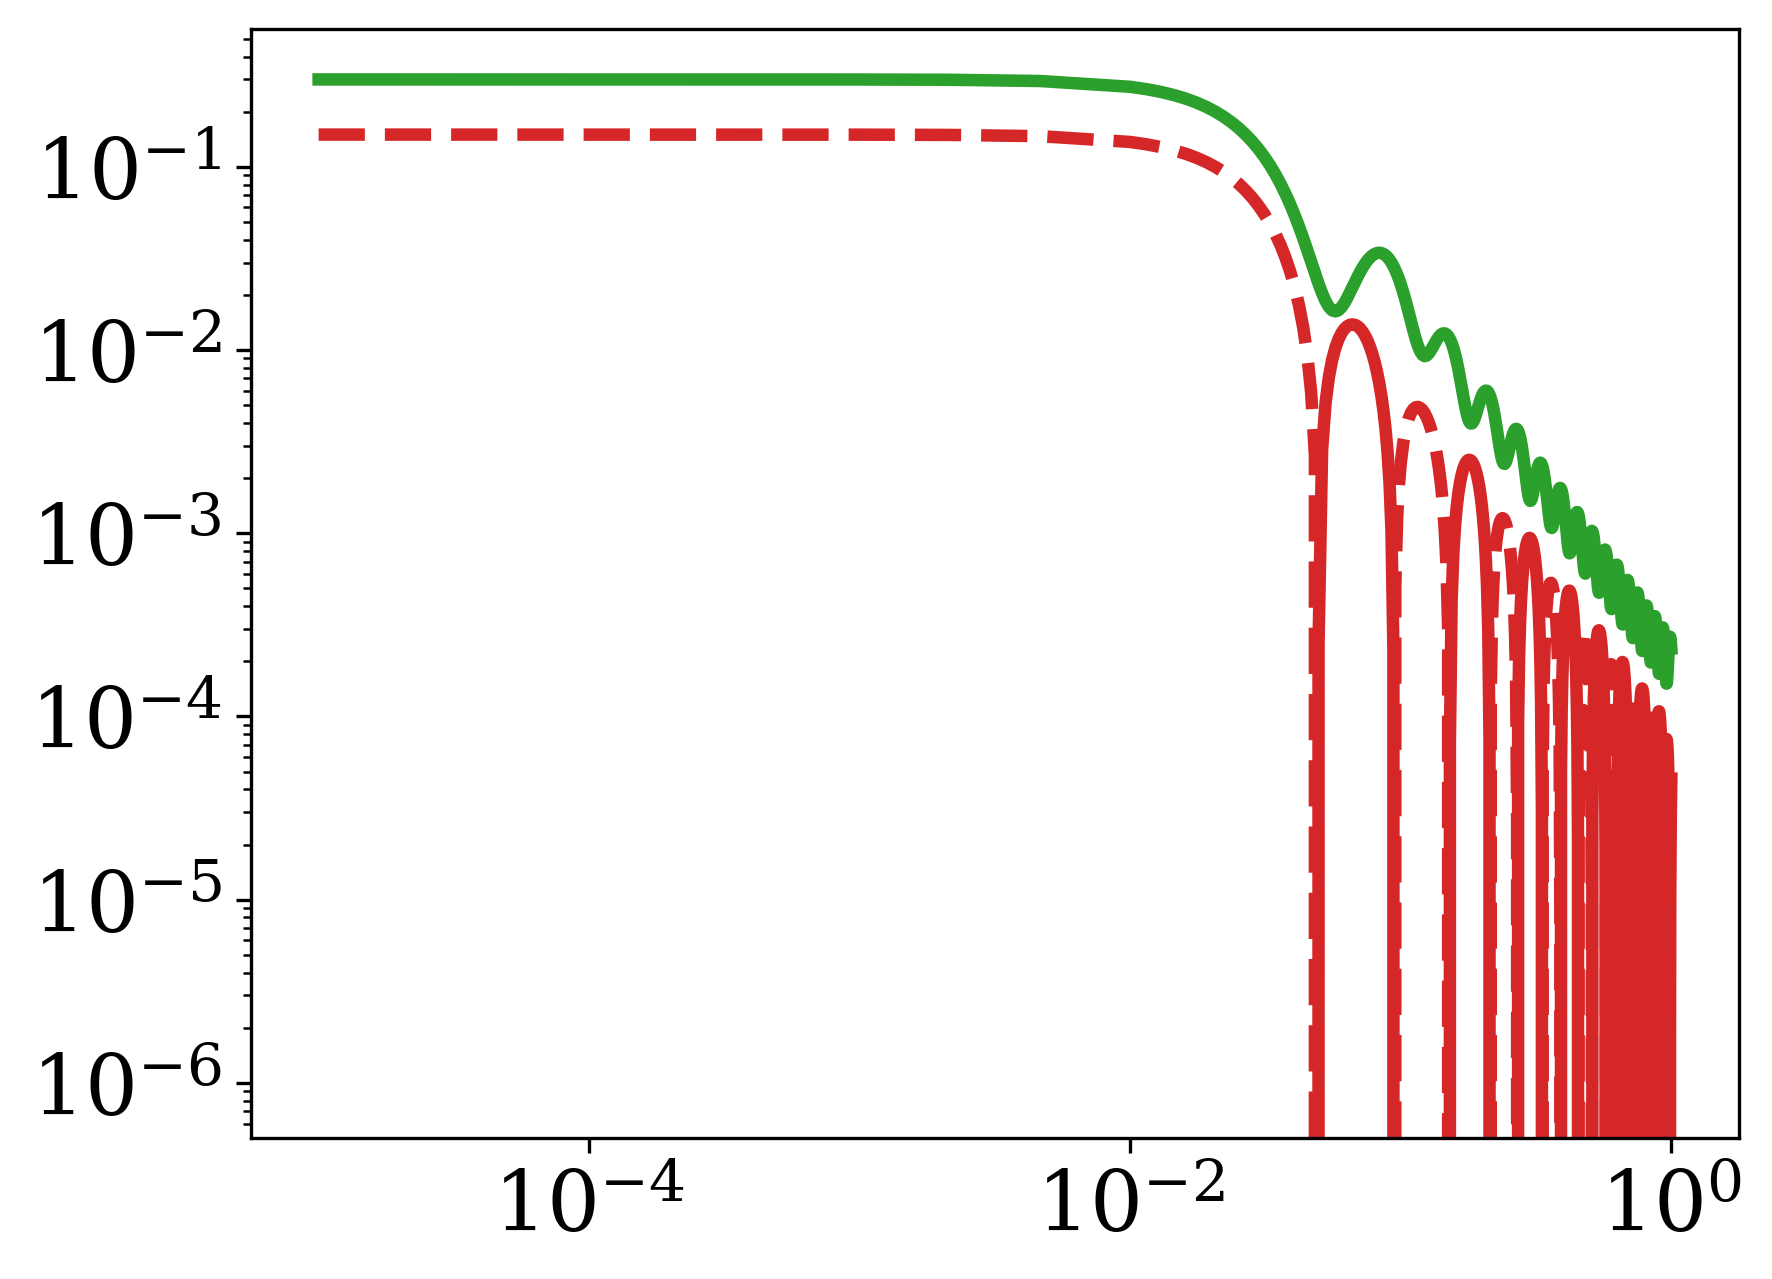

In [14]:
plt.loglog(f_vec,(R1_vec_ell),label='R1_ell',c='C2')
plt.loglog(f_vec,(R2_vec_ell),label='R2_ell',c='C3')
plt.loglog(f_vec,-(R2_vec_ell),label='-R2_ell',c='C3',linestyle='--')

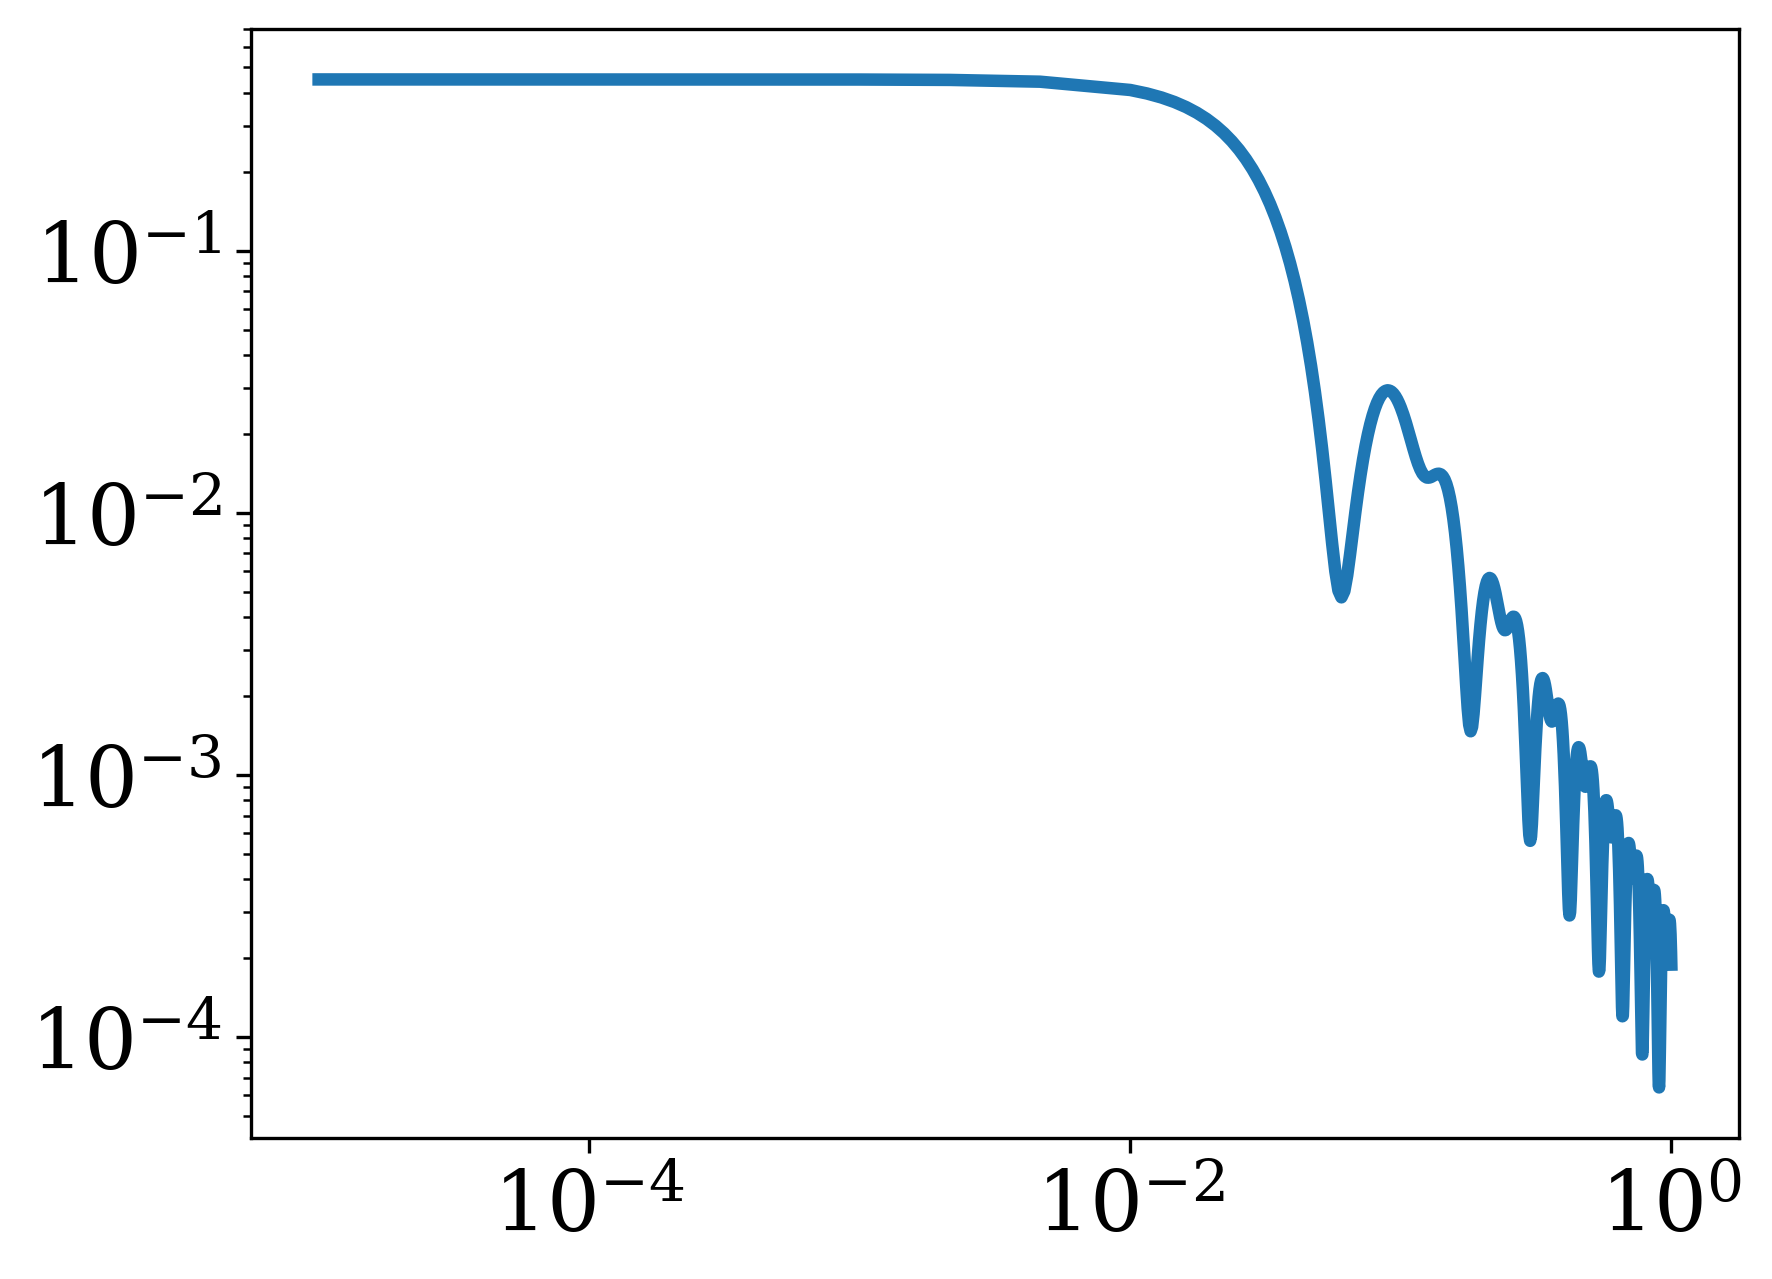

In [15]:
RAAell = R1_vec_ell - R2_vec_ell
plt.loglog(f_vec,(RAAell),label='RAA',c='C0')

In [16]:
def sum_m(l_det1,l_det2,x_det1,x_det2,f_vec,f_star,ell):
    m = np.linspace(-ell,ell,2*ell+1)
    Rell = np.zeros_like(f_vec,dtype=complex)
    #Rell = np.zeros_like(f_vec)
    for i in range(len(m)):
        R = Response_ell(l_det1,l_det2,x_det1,x_det2,f_vec,f_star,ell,m[i])
        #R2 = np.abs(Response_ell(l_det1,l_det2,x_det1,x_det2,f_vec,f_star,ell,m[i]))**2
        Rstar = np.conj(R)
        Rell += R*Rstar
        #Rell += R2
    return np.sqrt(Rell)

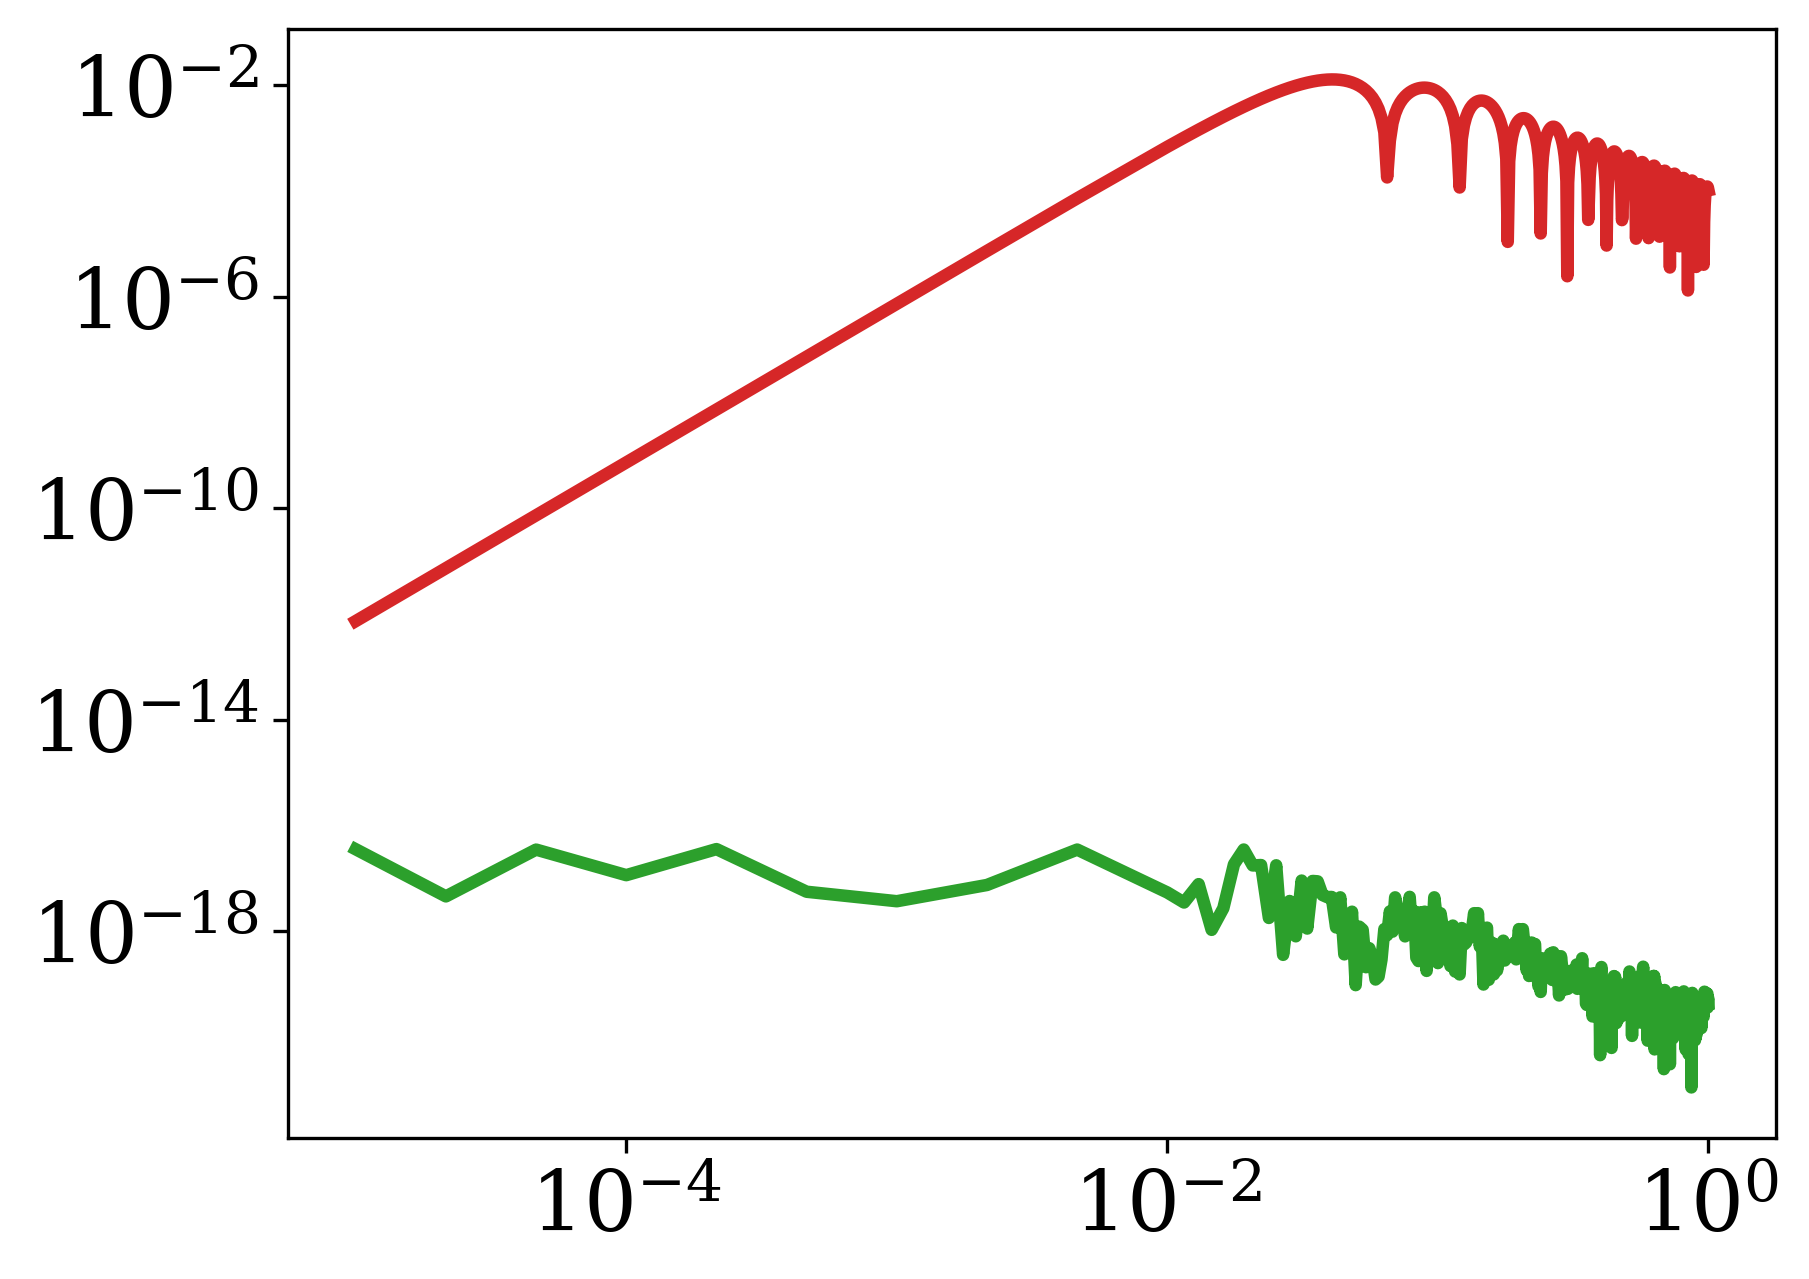

In [17]:
R11 = sum_m(lA,lA,xA,xA,f_vec,f_star,1)
R22 = sum_m(lA,lB,xA,xB,f_vec,f_star,1)
plt.loglog(f_vec,(R11),label='R11',c='C2')
plt.loglog(f_vec,(R22),label='R11',c='C3')

#plt.loglog(f_vec,(R2_vec),label='R2',c='C3')
#plt.loglog(f_vec,-(R2_vec),label='-R2',c='C3',linestyle='--')

In [18]:
def sum_m_AET(l_det1,l_det2,x_det1,x_det2,f_vec,f_star,ell):
    mvec = np.linspace(-ell,ell,2*ell+1)
    RlAA = np.zeros_like(f_vec,dtype=complex)
    RlTT = np.zeros_like(f_vec,dtype=complex)
    RlAE = np.zeros_like(f_vec,dtype=complex)
    RlAT = np.zeros_like(f_vec,dtype=complex)
    if int(ell)% 2 == 0:
        for m in mvec:
            R1 = Response_ell(l_det1,l_det1,x_det1,x_det1,f_vec,f_star,ell,m)
            R2 = Response_ell(l_det1,l_det2,x_det1,x_det2,f_vec,f_star,ell,m)
            #RAA = 1/4*np.abs(1+np.exp(-4/3*1j*m[i]*np.pi)*(Response_ell(l_det1,l_det2,x_det1,x_det2,f_vec,f_star,ell,m[i])))
            #RAE = 1/3*(1+2*np.cos(2*m[i]*np.pi/3))**2*np.abs(Response_ell(l_det1,l_det2,x_det1,x_det2,f_vec,f_star,ell,m[i]))**2
            RlAA += np.abs((1+np.exp(-4j/3*m*np.pi)) * R1 - 2 * R2)**2
            RlTT += np.abs(R1 + 2*R2)**2*(1+2*np.cos(2*m*np.pi/3))**2 
            RlAE += (np.sin(m*np.pi/3))**2 * np.abs((1+np.exp(2j/3*m*np.pi))*R1 - 2 * R2)**2
            RlAT += (np.sin(m*np.pi/3))**2 * np.abs((1+np.exp(2j/3*m*np.pi))*R1 + R2)**2
            #Rell_rot += RAE
    else:  
        for m in mvec:
            R2 = Response_ell(l_det1,l_det2,x_det1,x_det2,f_vec,f_star,ell,m)
            RlAE += (1+2*np.cos(2*m*np.pi/3))**2 * np.abs(R2)**2
            RlAT += (np.sin(m*np.pi/3)**2 * np.abs(R2)**2)*3
    return np.sqrt(np.real(RlAA)/4), np.sqrt(np.real(RlTT)/9), np.sqrt(np.real(RlAE)/3), np.sqrt(2*np.real(RlAT)/3)

In [29]:
R = sum_m_AET(lA,lB,xA,xB,f_vec,f_star,3)

starting l odd
AE
starting AE
-3
-2
-1
0
1
2
3
AT
starting AT
-3
-2
-1
0
1
2
3


starting l odd
AE
starting AE
-1
0
1
AT
starting AT
-1
0
1


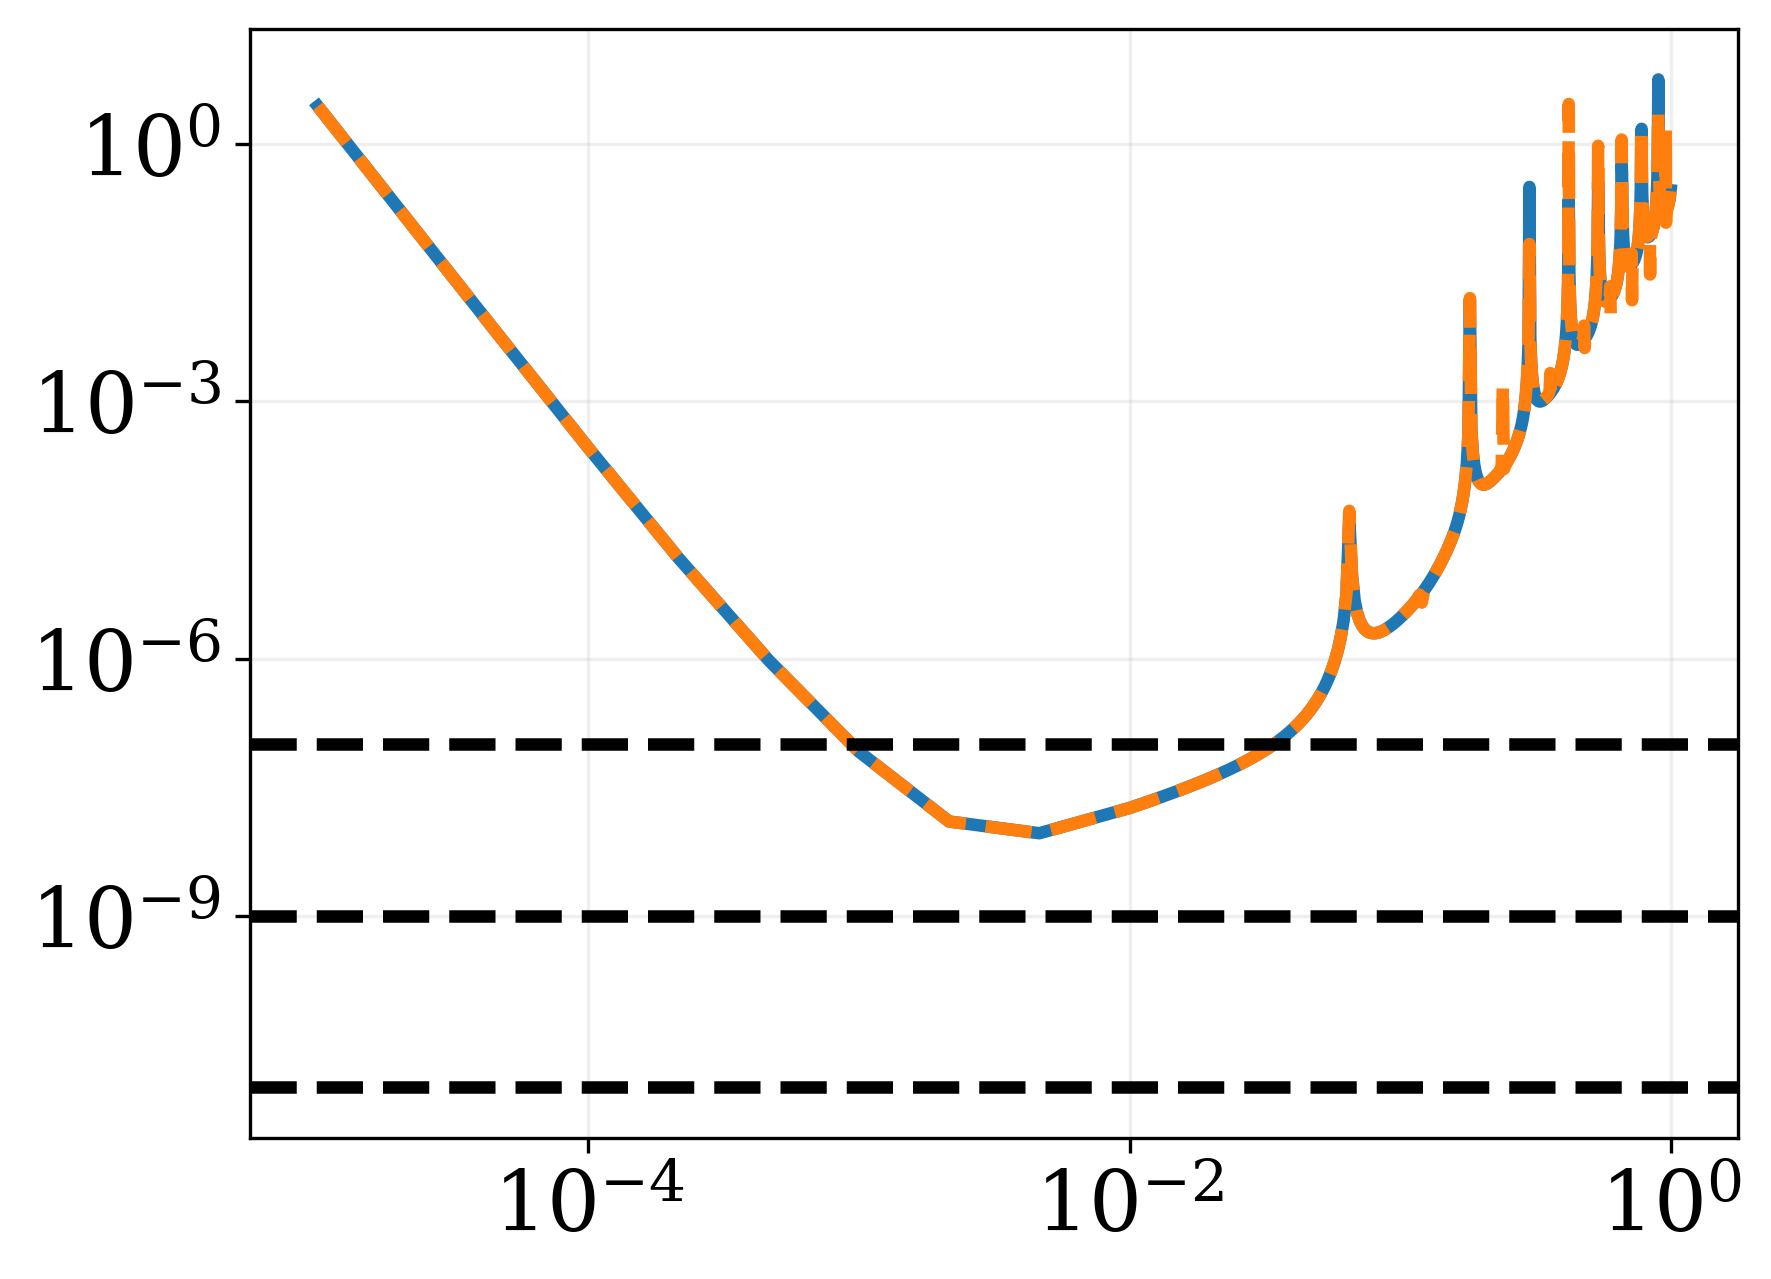

In [40]:
R1 = sum_m_AET(lA,lB,xA,xB,f_vec,f_star,1)

R_1_AA = R1[0]
R_1_TT = R1[1]
R_1_AE = R1[2]
R_1_AT = R1[3]
R_1_ET = R_1_AT

psd_A = detectors.LISA_noise_AET(f_vec, 'A')
psd_E = detectors.LISA_noise_AET(f_vec, 'E')
psd_T = detectors.LISA_noise_AET(f_vec, 'T')

h = 0.7

Nl_AE = 4 * np.pi**2 * np.sqrt(4*np.pi) / (3* (H0/h)**2) * f_vec**3 * np.sqrt(psd_A * psd_E) / R_1_AE
Nl_AT = 4 * np.pi**2 * np.sqrt(4*np.pi) / (3* (H0/h)**2) * f_vec**3 * np.sqrt(psd_A * psd_T) / R_1_AT
Nl_ET = 4 * np.pi**2 * np.sqrt(4*np.pi) / (3* (H0/h)**2) * f_vec**3 * np.sqrt(psd_E * psd_T) / R_1_ET

Nl = np.array([Nl_AE, Nl_AT, Nl_ET])

Omega1 = (np.sum(1/(Nl)**2, axis=0))**(-0.5)

Omega_1_t_LISA = nell.Sensitivity_ell.Omega_ell_LISA(f_vec, 1, 't')

plt.plot(f_vec, Omega1/np.sqrt(4*np.pi))
plt.plot(f_vec, Omega_1_t_LISA/np.sqrt(4*np.pi), linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.axhline(1e-11, color='k', linestyle='--')   
plt.axhline(1e-9, color='k', linestyle='--')
plt.axhline(1e-7, color='k', linestyle='--')
plt.grid(alpha=0.2, which='both')


starting l odd
AE
starting AE
-3
-2
-1
0
1
2
3
AT
starting AT
-3
-2
-1
0
1
2
3


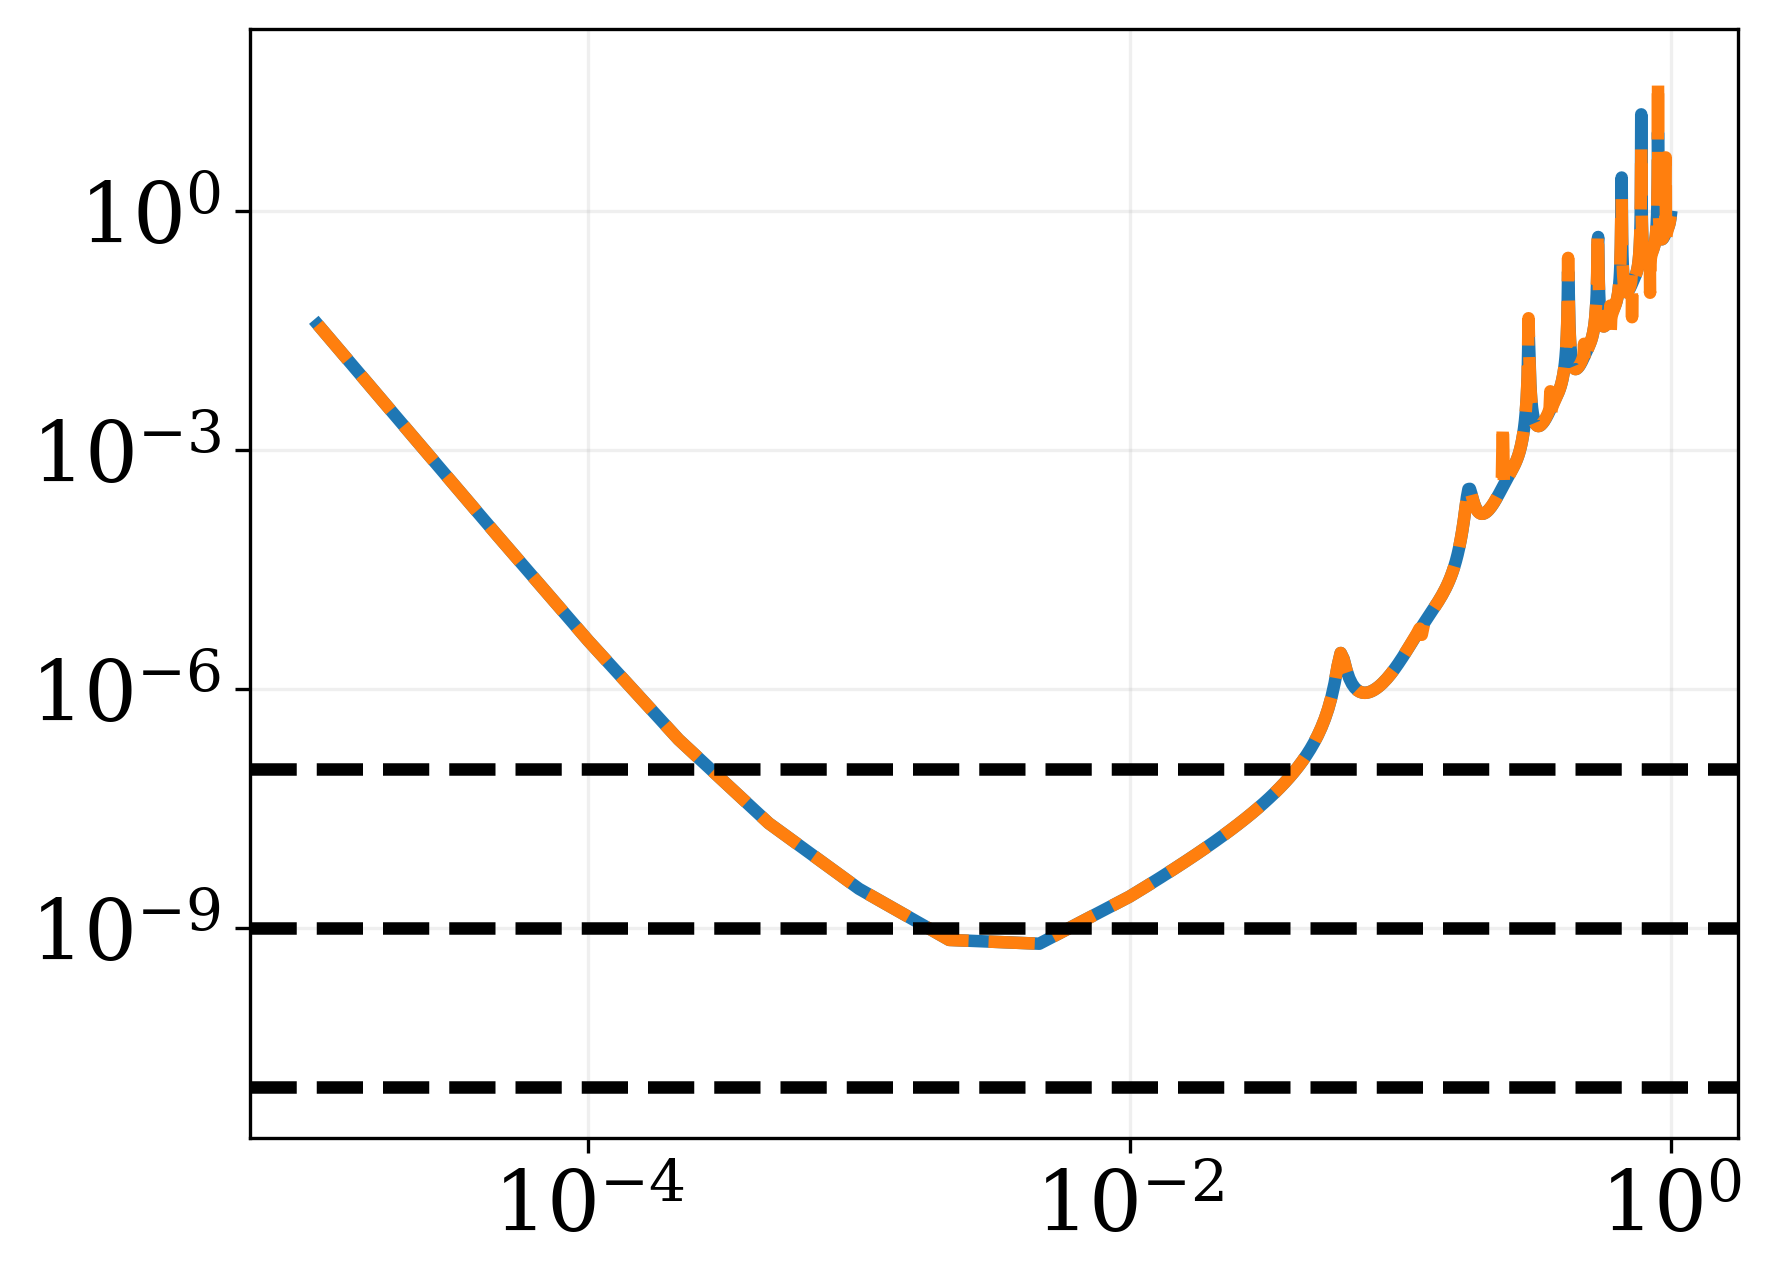

In [44]:
R3 = sum_m_AET(lA,lB,xA,xB,f_vec,f_star,3)

R_3_AA = R3[0]
R_3_TT = R3[1]
R_3_AE = R3[2]
R_3_AT = R3[3]
R_3_ET = R_1_AT

psd_A = detectors.LISA_noise_AET(f_vec, 'A')
psd_E = detectors.LISA_noise_AET(f_vec, 'E')
psd_T = detectors.LISA_noise_AET(f_vec, 'T')

h = 0.7

Nl_AE = 4 * np.pi**2 * np.sqrt(4*np.pi) / (3* (H0/h)**2) * f_vec**3 * np.sqrt(psd_A * psd_E) / R_3_AE
Nl_AT = 4 * np.pi**2 * np.sqrt(4*np.pi) / (3* (H0/h)**2) * f_vec**3 * np.sqrt(psd_A * psd_T) / R_3_AT
Nl_ET = 4 * np.pi**2 * np.sqrt(4*np.pi) / (3* (H0/h)**2) * f_vec**3 * np.sqrt(psd_E * psd_T) / R_3_ET

Nl = np.array([Nl_AE, Nl_AT, Nl_ET])

Omega3 = np.sum(1/(Nl)**2, axis=0)**(-0.5)

Omega_3_t_LISA = nell.Sensitivity_ell.Omega_ell_LISA(f_vec, 3, 't')

plt.plot(f_vec, Omega3/np.sqrt(4*np.pi))
plt.plot(f_vec, Omega_3_t_LISA/np.sqrt(4*np.pi), linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.axhline(1e-11, color='k', linestyle='--')   
plt.axhline(1e-9, color='k', linestyle='--')
plt.axhline(1e-7, color='k', linestyle='--')
plt.grid(alpha=0.2, which='both')

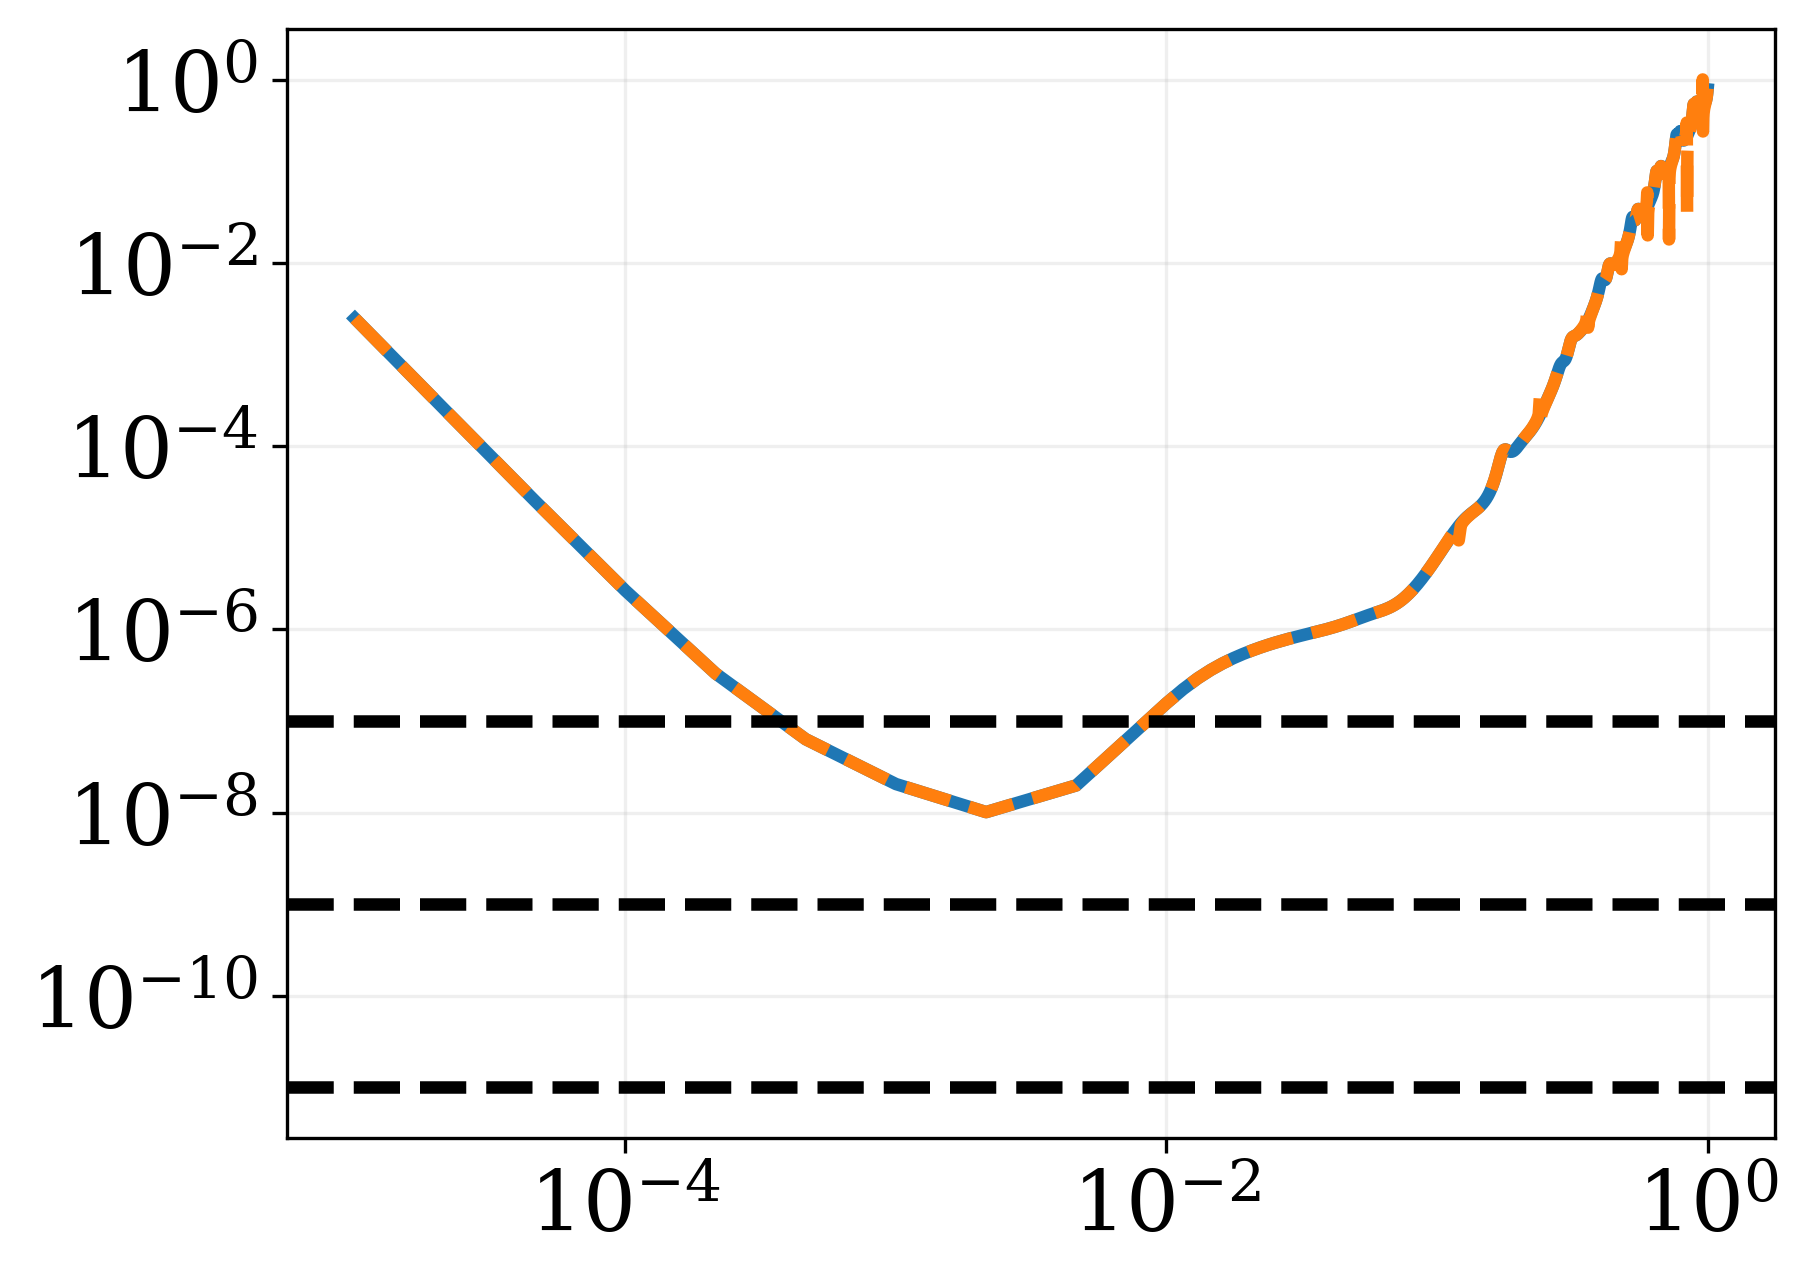

In [37]:
R6 = sum_m_AET(lA,lB,xA,xB,f_vec,f_star,6)

R_6_AA = R6[0]
R_6_EE = R_6_AA
R_6_TT = R6[1]
R_6_AE = R6[2]
R_6_AT = R6[3]
R_6_ET = R_6_AT

psd_A = detectors.LISA_noise_AET(f_vec, 'A')
psd_E = detectors.LISA_noise_AET(f_vec, 'E')
psd_T = detectors.LISA_noise_AET(f_vec, 'T')

h = 0.7

Nl_AA = 4 * np.pi**2 * np.sqrt(4*np.pi) / (3* (H0/h)**2) * f_vec**3 * np.sqrt(psd_A * psd_A) / R_6_AA
Nl_EE = 4 * np.pi**2 * np.sqrt(4*np.pi) / (3* (H0/h)**2) * f_vec**3 * np.sqrt(psd_E * psd_E) / R_6_EE
Nl_TT = 4 * np.pi**2 * np.sqrt(4*np.pi) / (3* (H0/h)**2) * f_vec**3 * np.sqrt(psd_T * psd_T) / R_6_TT
Nl_AE = 4 * np.pi**2 * np.sqrt(4*np.pi) / (3* (H0/h)**2) * f_vec**3 * np.sqrt(psd_A * psd_E) / R_6_AE
Nl_AT = 4 * np.pi**2 * np.sqrt(4*np.pi) / (3* (H0/h)**2) * f_vec**3 * np.sqrt(psd_A * psd_T) / R_6_AT
Nl_ET = 4 * np.pi**2 * np.sqrt(4*np.pi) / (3* (H0/h)**2) * f_vec**3 * np.sqrt(psd_E * psd_T) / R_6_ET

Nl = np.array([Nl_AA, Nl_EE, Nl_TT, Nl_AE, Nl_AT, Nl_ET])

Omega6 = np.sum(1/(Nl)**2, axis=0)**(-0.5)

Omega_6_t_LISA = nell.Sensitivity_ell.Omega_ell_LISA(f_vec, 6, 't')


plt.plot(f_vec, Omega6/np.sqrt(4*np.pi))
plt.plot(f_vec, Omega_6_t_LISA/np.sqrt(4*np.pi), linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.axhline(1e-11, color='k', linestyle='--')   
plt.axhline(1e-9, color='k', linestyle='--')
plt.axhline(1e-7, color='k', linestyle='--')
plt.grid(alpha=0.2, which='both')

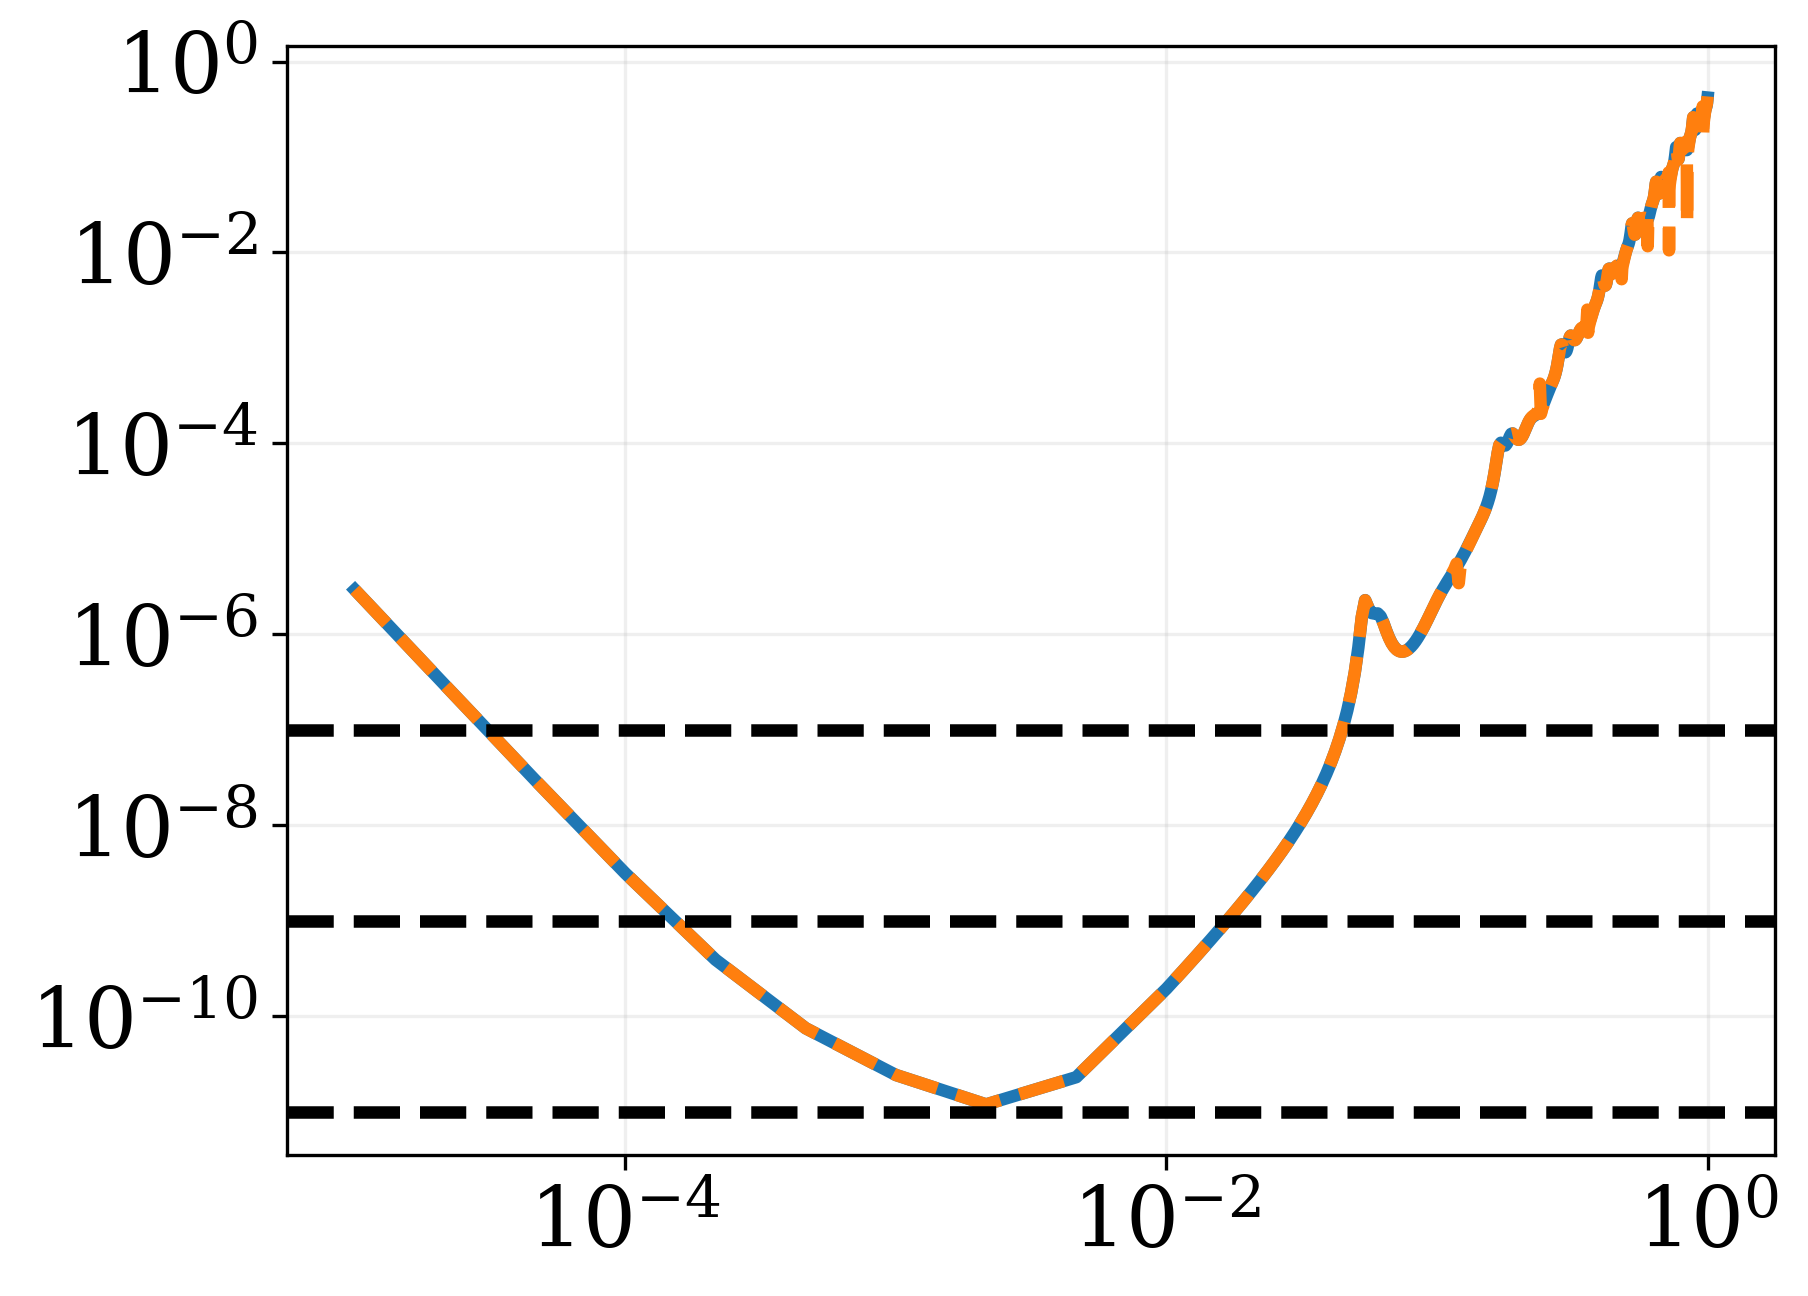

In [41]:
R2 = sum_m_AET(lA,lB,xA,xB,f_vec,f_star,2)

R_2_AA = R2[0]
R_2_EE = R_2_AA
R_2_TT = R2[1]
R_2_AE = R2[2]
R_2_AT = R2[3]
R_2_ET = R_2_AT

psd_A = detectors.LISA_noise_AET(f_vec, 'A')
psd_E = detectors.LISA_noise_AET(f_vec, 'E')
psd_T = detectors.LISA_noise_AET(f_vec, 'T')

h = 0.7

Nl_AA = 4 * np.pi**2 * np.sqrt(4*np.pi) / (3* (H0/h)**2) * f_vec**3 * np.sqrt(psd_A * psd_A) / R_2_AA
Nl_EE = 4 * np.pi**2 * np.sqrt(4*np.pi) / (3* (H0/h)**2) * f_vec**3 * np.sqrt(psd_E * psd_E) / R_2_EE
Nl_TT = 4 * np.pi**2 * np.sqrt(4*np.pi) / (3* (H0/h)**2) * f_vec**3 * np.sqrt(psd_T * psd_T) / R_2_TT
Nl_AE = 4 * np.pi**2 * np.sqrt(4*np.pi) / (3* (H0/h)**2) * f_vec**3 * np.sqrt(psd_A * psd_E) / R_2_AE
Nl_AT = 4 * np.pi**2 * np.sqrt(4*np.pi) / (3* (H0/h)**2) * f_vec**3 * np.sqrt(psd_A * psd_T) / R_2_AT
Nl_ET = 4 * np.pi**2 * np.sqrt(4*np.pi) / (3* (H0/h)**2) * f_vec**3 * np.sqrt(psd_E * psd_T) / R_2_ET

Nl = np.array([Nl_AA, Nl_EE, Nl_TT, Nl_AE, Nl_AT, Nl_ET])

Omega2 = np.sum(1/(Nl)**2, axis=0)**(-0.5)

Omega_2_t_LISA = nell.Sensitivity_ell.Omega_ell_LISA(f_vec, 2, 't')


plt.plot(f_vec, Omega2/np.sqrt(4*np.pi))
plt.plot(f_vec, Omega_2_t_LISA/np.sqrt(4*np.pi), linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.axhline(1e-11, color='k', linestyle='--')   
plt.axhline(1e-9, color='k', linestyle='--')
plt.axhline(1e-7, color='k', linestyle='--')
plt.grid(alpha=0.2, which='both')

/var/folders/5d/ymf225n1541cfw2gc3hlv41w0000gn/T/ipykernel_18754/1420059225.py:19: RuntimeWarning: divide by zero encountered in divide
  Nl_AE = 4 * np.pi**2 * np.sqrt(4*np.pi) / (3* (H0/h)**2) * f_vec**3 * np.sqrt(psd_A * psd_E) / R_0_AE
/var/folders/5d/ymf225n1541cfw2gc3hlv41w0000gn/T/ipykernel_18754/1420059225.py:20: RuntimeWarning: divide by zero encountered in divide
  Nl_AT = 4 * np.pi**2 * np.sqrt(4*np.pi) / (3* (H0/h)**2) * f_vec**3 * np.sqrt(psd_A * psd_T) / R_0_AT
/var/folders/5d/ymf225n1541cfw2gc3hlv41w0000gn/T/ipykernel_18754/1420059225.py:21: RuntimeWarning: divide by zero encountered in divide
  Nl_ET = 4 * np.pi**2 * np.sqrt(4*np.pi) / (3* (H0/h)**2) * f_vec**3 * np.sqrt(psd_E * psd_T) / R_0_ET


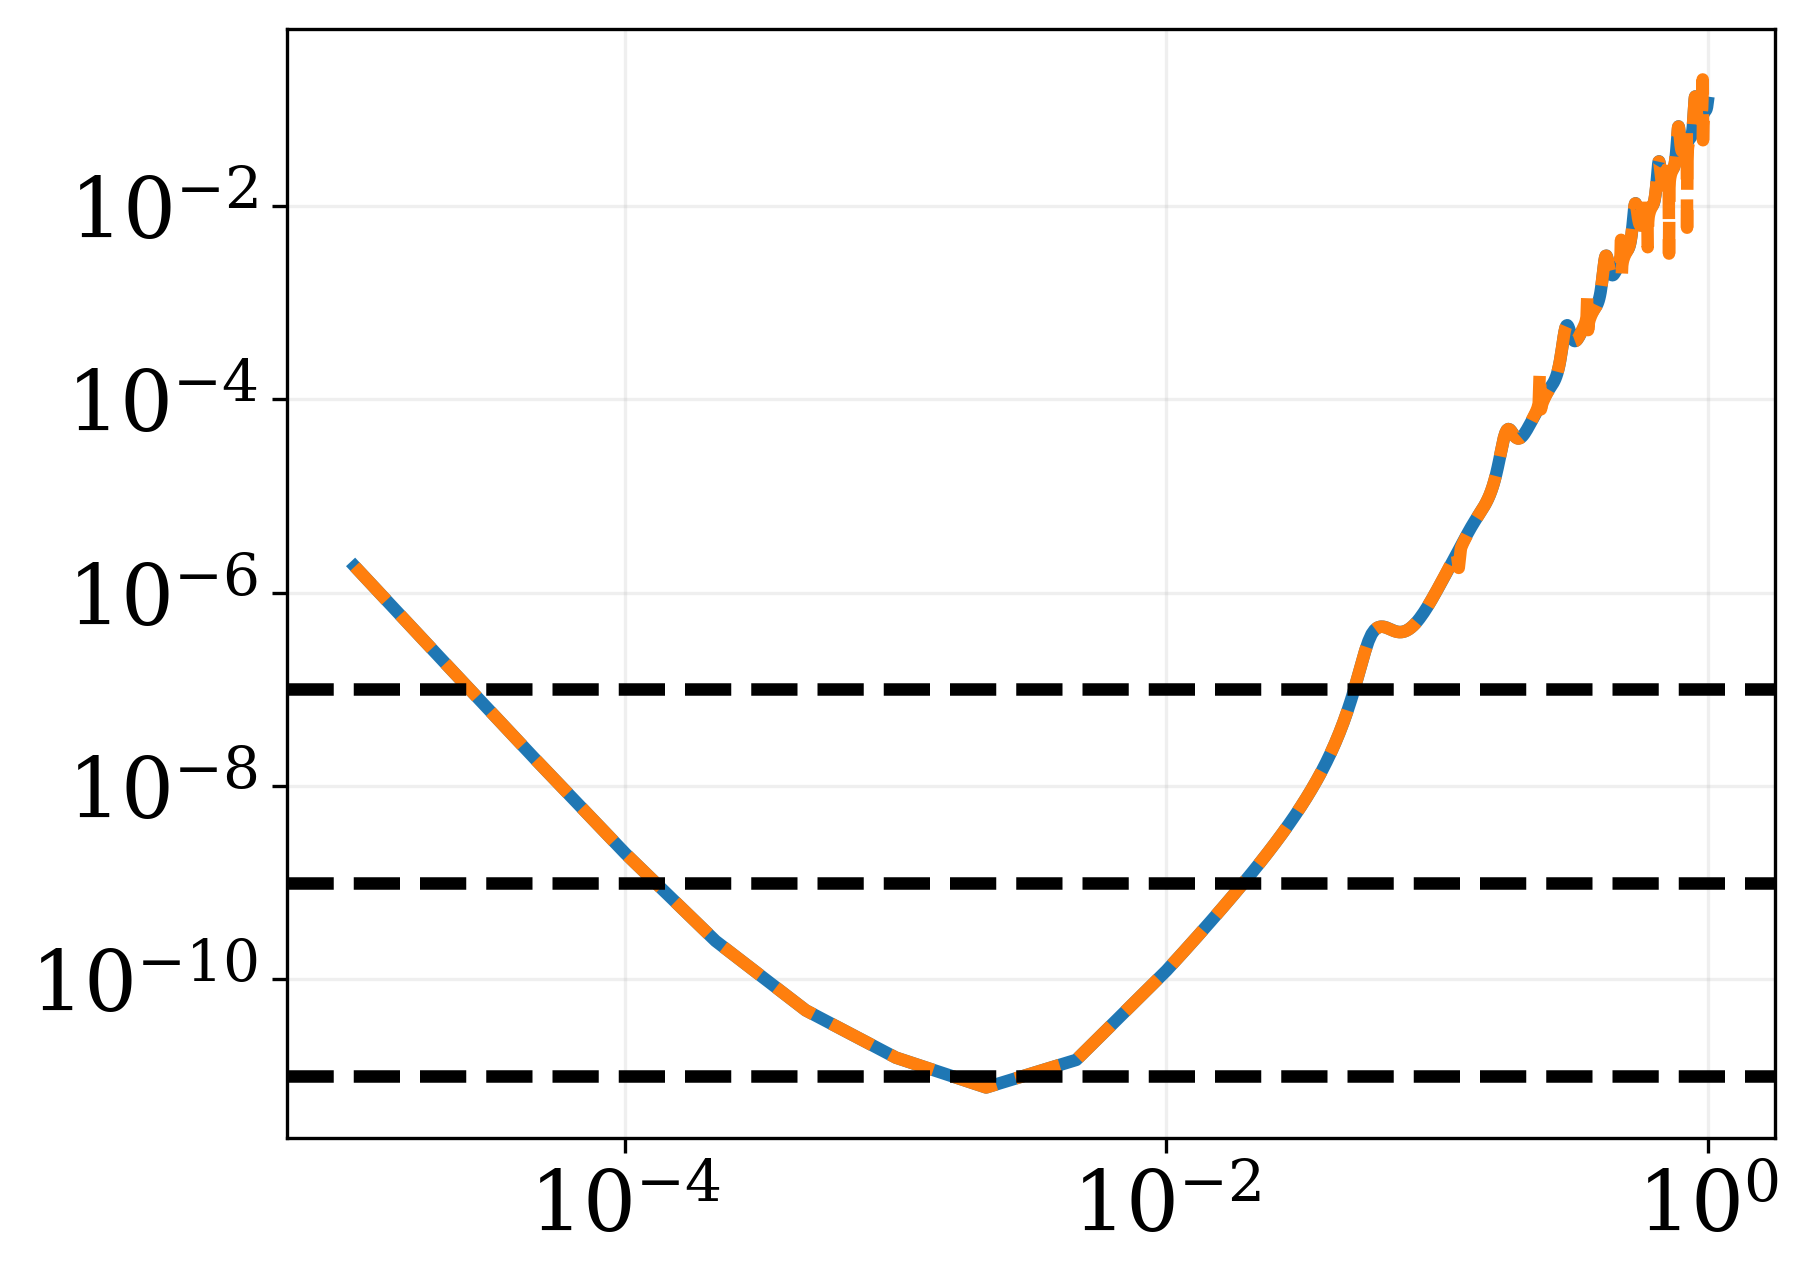

In [47]:
R0 = sum_m_AET(lA,lB,xA,xB,f_vec,f_star,0)

R_0_AA = R0[0]
R_0_EE = R_0_AA
R_0_TT = R0[1]
R_0_AE = R0[2]
R_0_AT = R0[3]
R_0_ET = R_0_AT

psd_A = detectors.LISA_noise_AET(f_vec, 'A')
psd_E = detectors.LISA_noise_AET(f_vec, 'E')
psd_T = detectors.LISA_noise_AET(f_vec, 'T')

h = 0.7

Nl_AA = 4 * np.pi**2 * np.sqrt(4*np.pi) / (3* (H0/h)**2) * f_vec**3 * np.sqrt(psd_A * psd_A) / R_0_AA
Nl_EE = 4 * np.pi**2 * np.sqrt(4*np.pi) / (3* (H0/h)**2) * f_vec**3 * np.sqrt(psd_E * psd_E) / R_0_EE
Nl_TT = 4 * np.pi**2 * np.sqrt(4*np.pi) / (3* (H0/h)**2) * f_vec**3 * np.sqrt(psd_T * psd_T) / R_0_TT
Nl_AE = 4 * np.pi**2 * np.sqrt(4*np.pi) / (3* (H0/h)**2) * f_vec**3 * np.sqrt(psd_A * psd_E) / R_0_AE
Nl_AT = 4 * np.pi**2 * np.sqrt(4*np.pi) / (3* (H0/h)**2) * f_vec**3 * np.sqrt(psd_A * psd_T) / R_0_AT
Nl_ET = 4 * np.pi**2 * np.sqrt(4*np.pi) / (3* (H0/h)**2) * f_vec**3 * np.sqrt(psd_E * psd_T) / R_0_ET

Nl = np.array([Nl_AA, Nl_EE, Nl_TT, Nl_AE, Nl_AT, Nl_ET])

Omega0 = np.sum(1/(Nl)**2, axis=0)**(-0.5)

Omega_0_t_LISA = nell.Sensitivity_ell.Omega_ell_LISA(f_vec, 0, 't')


plt.plot(f_vec, Omega0/np.sqrt(4*np.pi))
plt.plot(f_vec, Omega_0_t_LISA/np.sqrt(4*np.pi), linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.axhline(1e-11, color='k', linestyle='--')   
plt.axhline(1e-9, color='k', linestyle='--')
plt.axhline(1e-7, color='k', linestyle='--')
plt.grid(alpha=0.2, which='both')

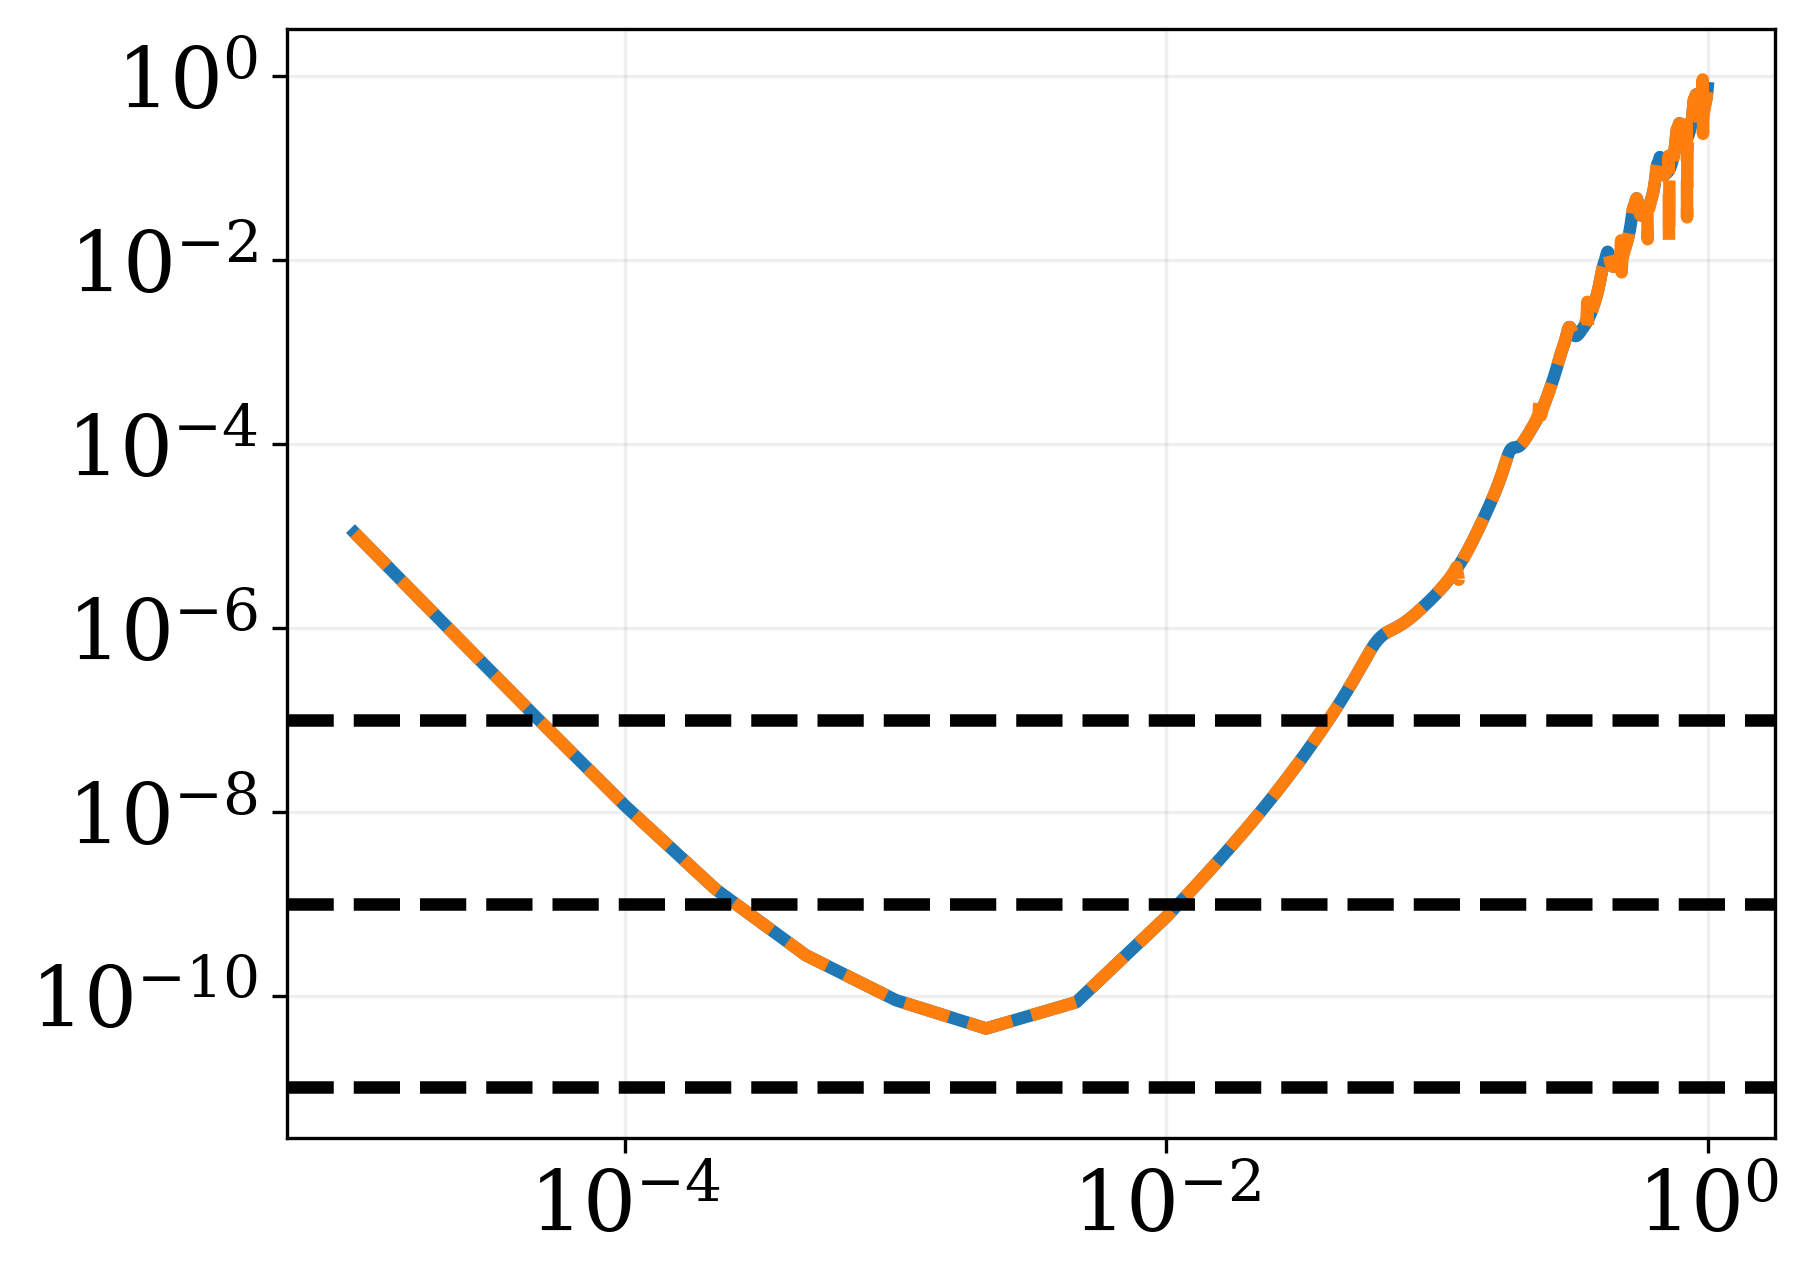

In [48]:
R4 = sum_m_AET(lA,lB,xA,xB,f_vec,f_star,4)

R_4_AA = R4[0]
R_4_EE = R_4_AA
R_4_TT = R4[1]
R_4_AE = R4[2]
R_4_AT = R4[3]
R_4_ET = R_4_AT

psd_A = detectors.LISA_noise_AET(f_vec, 'A')
psd_E = detectors.LISA_noise_AET(f_vec, 'E')
psd_T = detectors.LISA_noise_AET(f_vec, 'T')

h = 0.7

Nl_AA = 4 * np.pi**2 * np.sqrt(4*np.pi) / (3* (H0/h)**2) * f_vec**3 * np.sqrt(psd_A * psd_A) / R_4_AA
Nl_EE = 4 * np.pi**2 * np.sqrt(4*np.pi) / (3* (H0/h)**2) * f_vec**3 * np.sqrt(psd_E * psd_E) / R_4_EE
Nl_TT = 4 * np.pi**2 * np.sqrt(4*np.pi) / (3* (H0/h)**2) * f_vec**3 * np.sqrt(psd_T * psd_T) / R_4_TT
Nl_AE = 4 * np.pi**2 * np.sqrt(4*np.pi) / (3* (H0/h)**2) * f_vec**3 * np.sqrt(psd_A * psd_E) / R_4_AE
Nl_AT = 4 * np.pi**2 * np.sqrt(4*np.pi) / (3* (H0/h)**2) * f_vec**3 * np.sqrt(psd_A * psd_T) / R_4_AT
Nl_ET = 4 * np.pi**2 * np.sqrt(4*np.pi) / (3* (H0/h)**2) * f_vec**3 * np.sqrt(psd_E * psd_T) / R_4_ET

Nl = np.array([Nl_AA, Nl_EE, Nl_TT, Nl_AE, Nl_AT, Nl_ET])

Omega4 = np.sum(1/(Nl)**2, axis=0)**(-0.5)

Omega_4_t_LISA = nell.Sensitivity_ell.Omega_ell_LISA(f_vec, 4, 't')


plt.plot(f_vec, Omega4/np.sqrt(4*np.pi))
plt.plot(f_vec, Omega_4_t_LISA/np.sqrt(4*np.pi), linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.axhline(1e-11, color='k', linestyle='--')   
plt.axhline(1e-9, color='k', linestyle='--')
plt.axhline(1e-7, color='k', linestyle='--')
plt.grid(alpha=0.2, which='both')

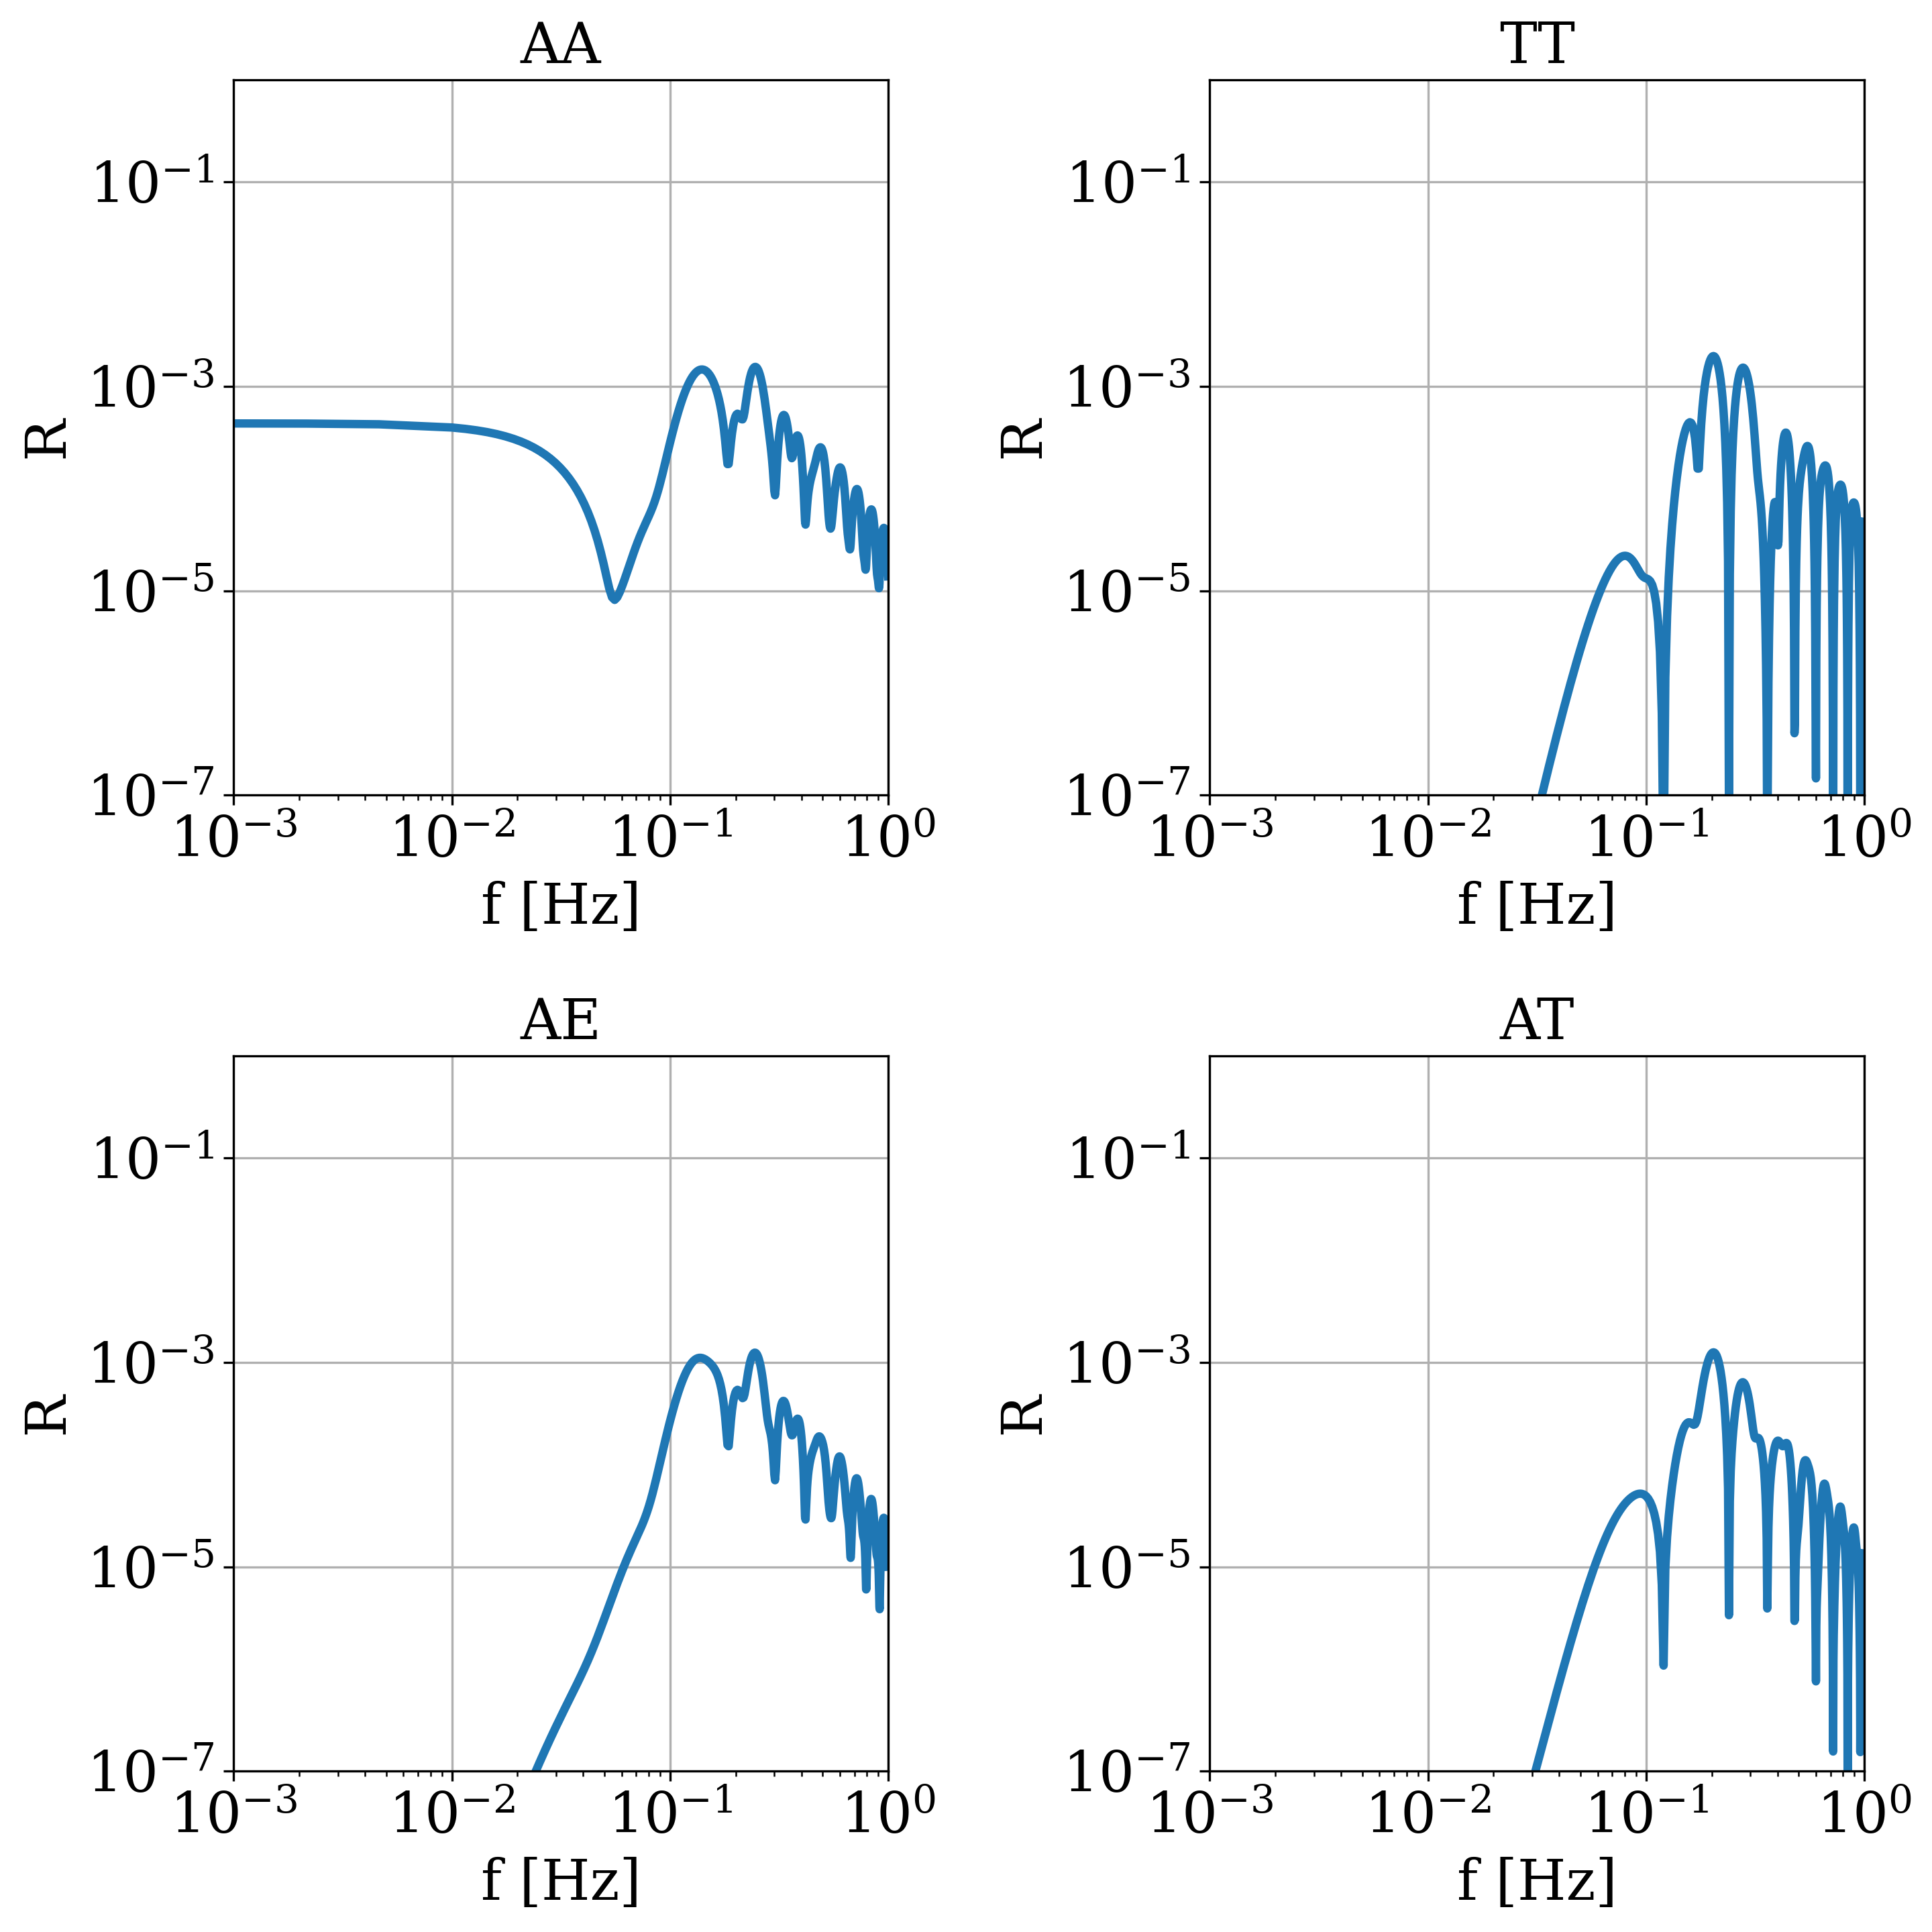

In [20]:
#f_vec = np.array([1e-3,1e-2])
l_value = 10
R = sum_m_AET(lA,lB,xA,xB,f_vec,f_star,l_value)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
ax = axs.flatten()
for i, axis in enumerate(ax):
    axis.set_xlim(1e-3, 1)
    axis.set_ylim(1e-7, 1)
    axis.set_title(['AA','TT','AE','AT'][i])
    axis.loglog(f_vec, R[i])
    axis.set_xlabel('f [Hz]')
    axis.set_ylabel('R')
    axis.grid()
plt.tight_layout()
plt.show()

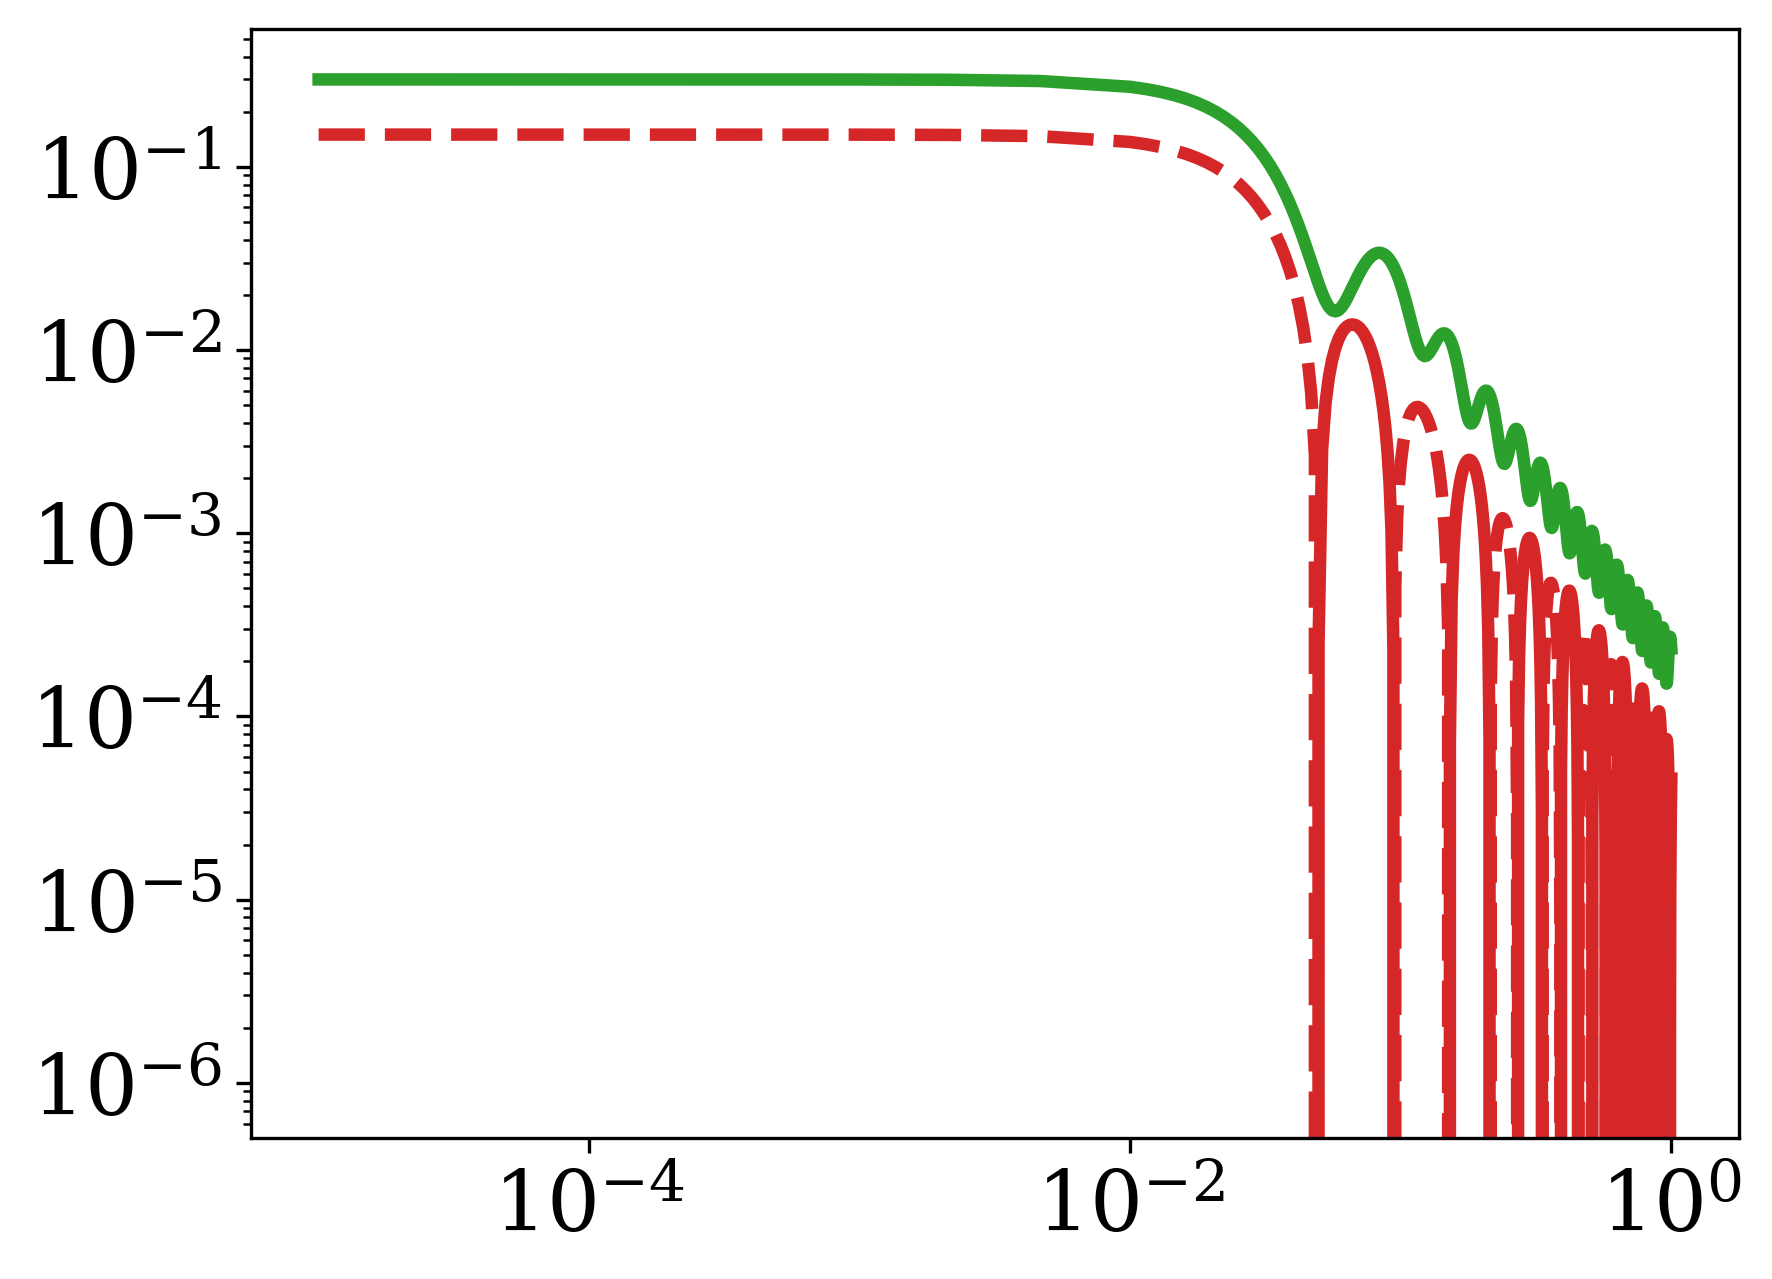

In [21]:
plt.loglog(f_vec,(R1_vec),label='R1',c='C2')
plt.loglog(f_vec,(R2_vec),label='R2',c='C3')
plt.loglog(f_vec,-(R2_vec),label='-R2',c='C3',linestyle='--')

In [22]:
RAA = R1_vec - R2_vec
RTT = R1_vec + 2*R2_vec

(1e-05, 1)

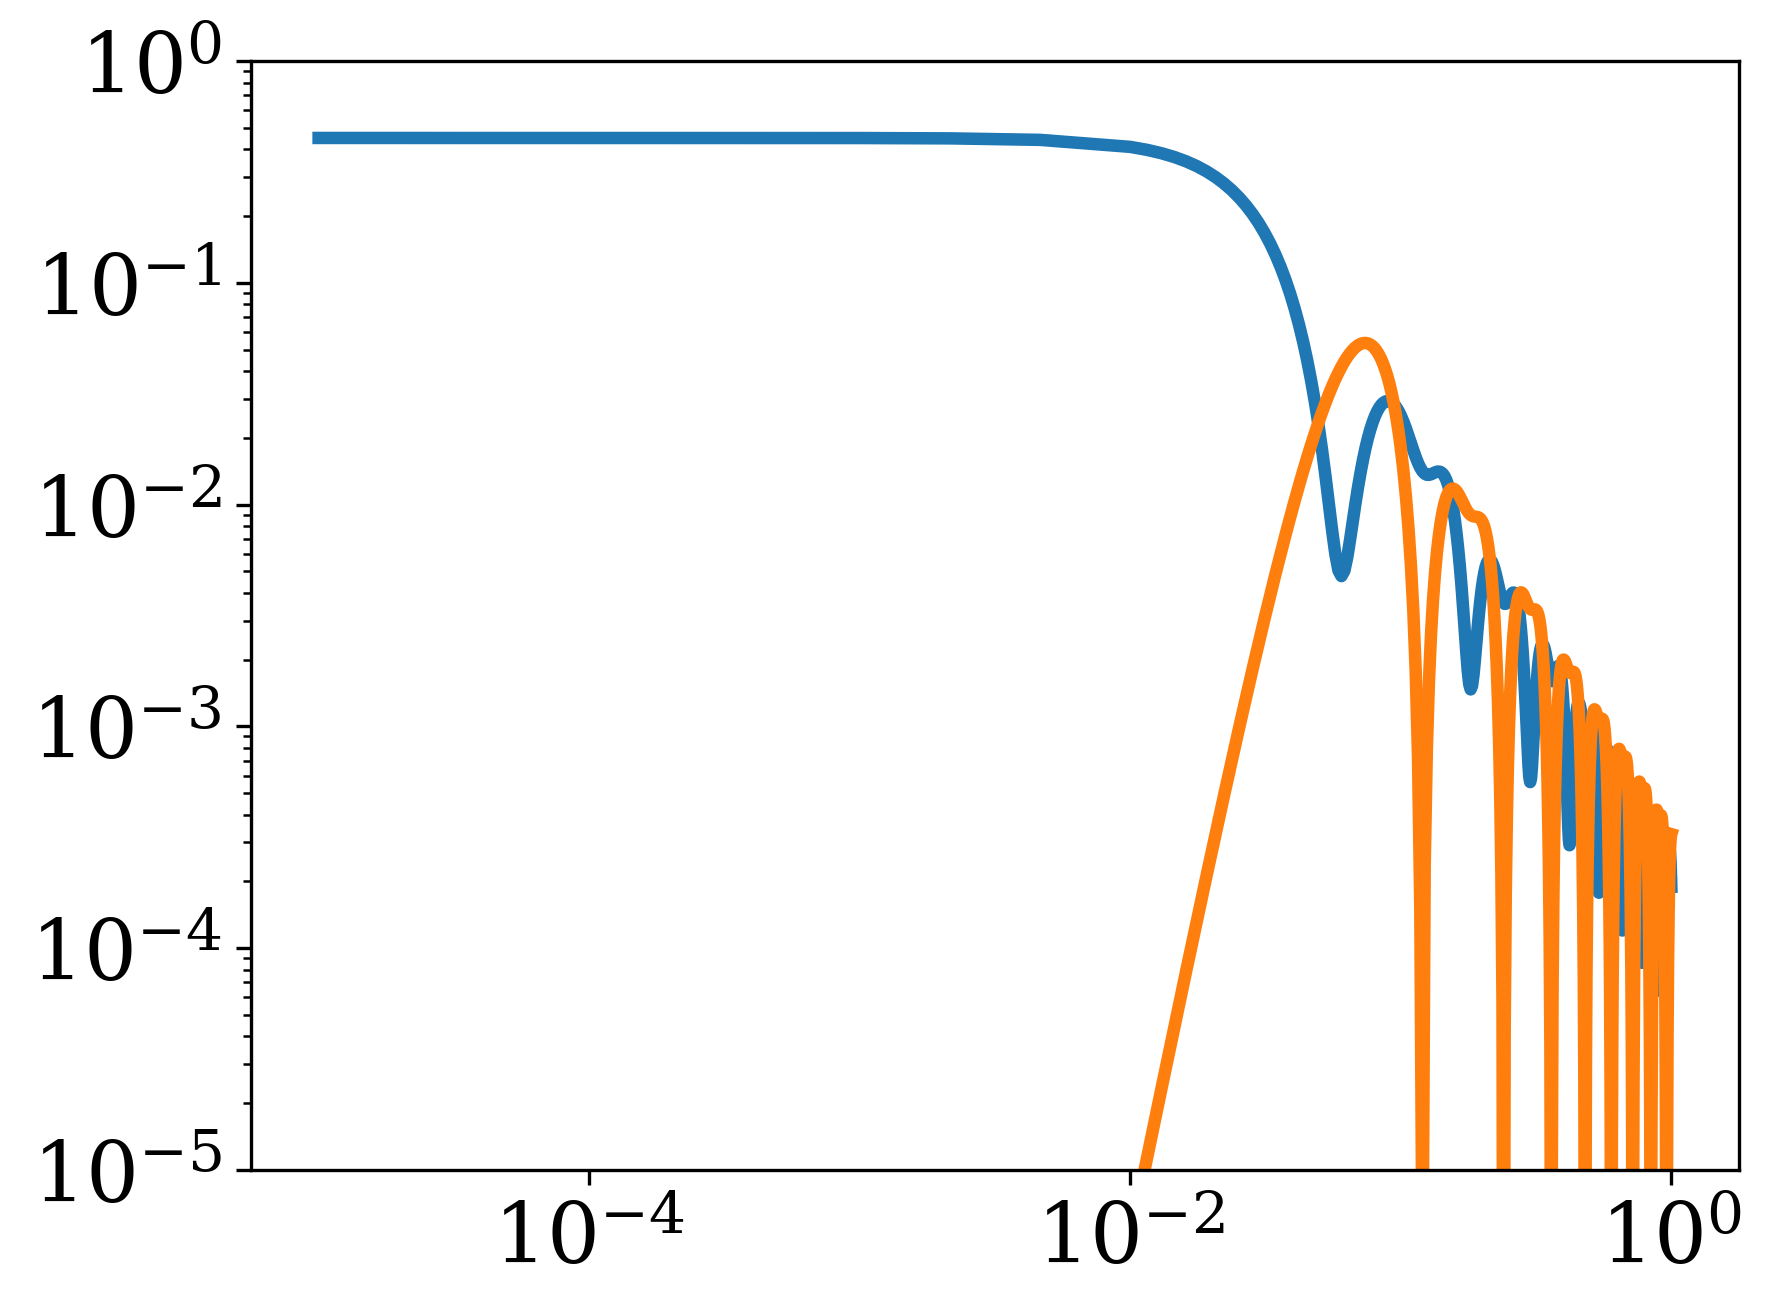

In [23]:
plt.plot(f_vec,RAA)
plt.plot(f_vec,RTT)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-5,1)

In [24]:
R6 = sum_m_AET(lA,lB,xA,xB,f_vec,f_star,6)

In [25]:
LISA_Rell_6_AA = nell.AngularResponse.R_ell_AET(6, 'AA', 't', f_vec)


(1e-05, 1)

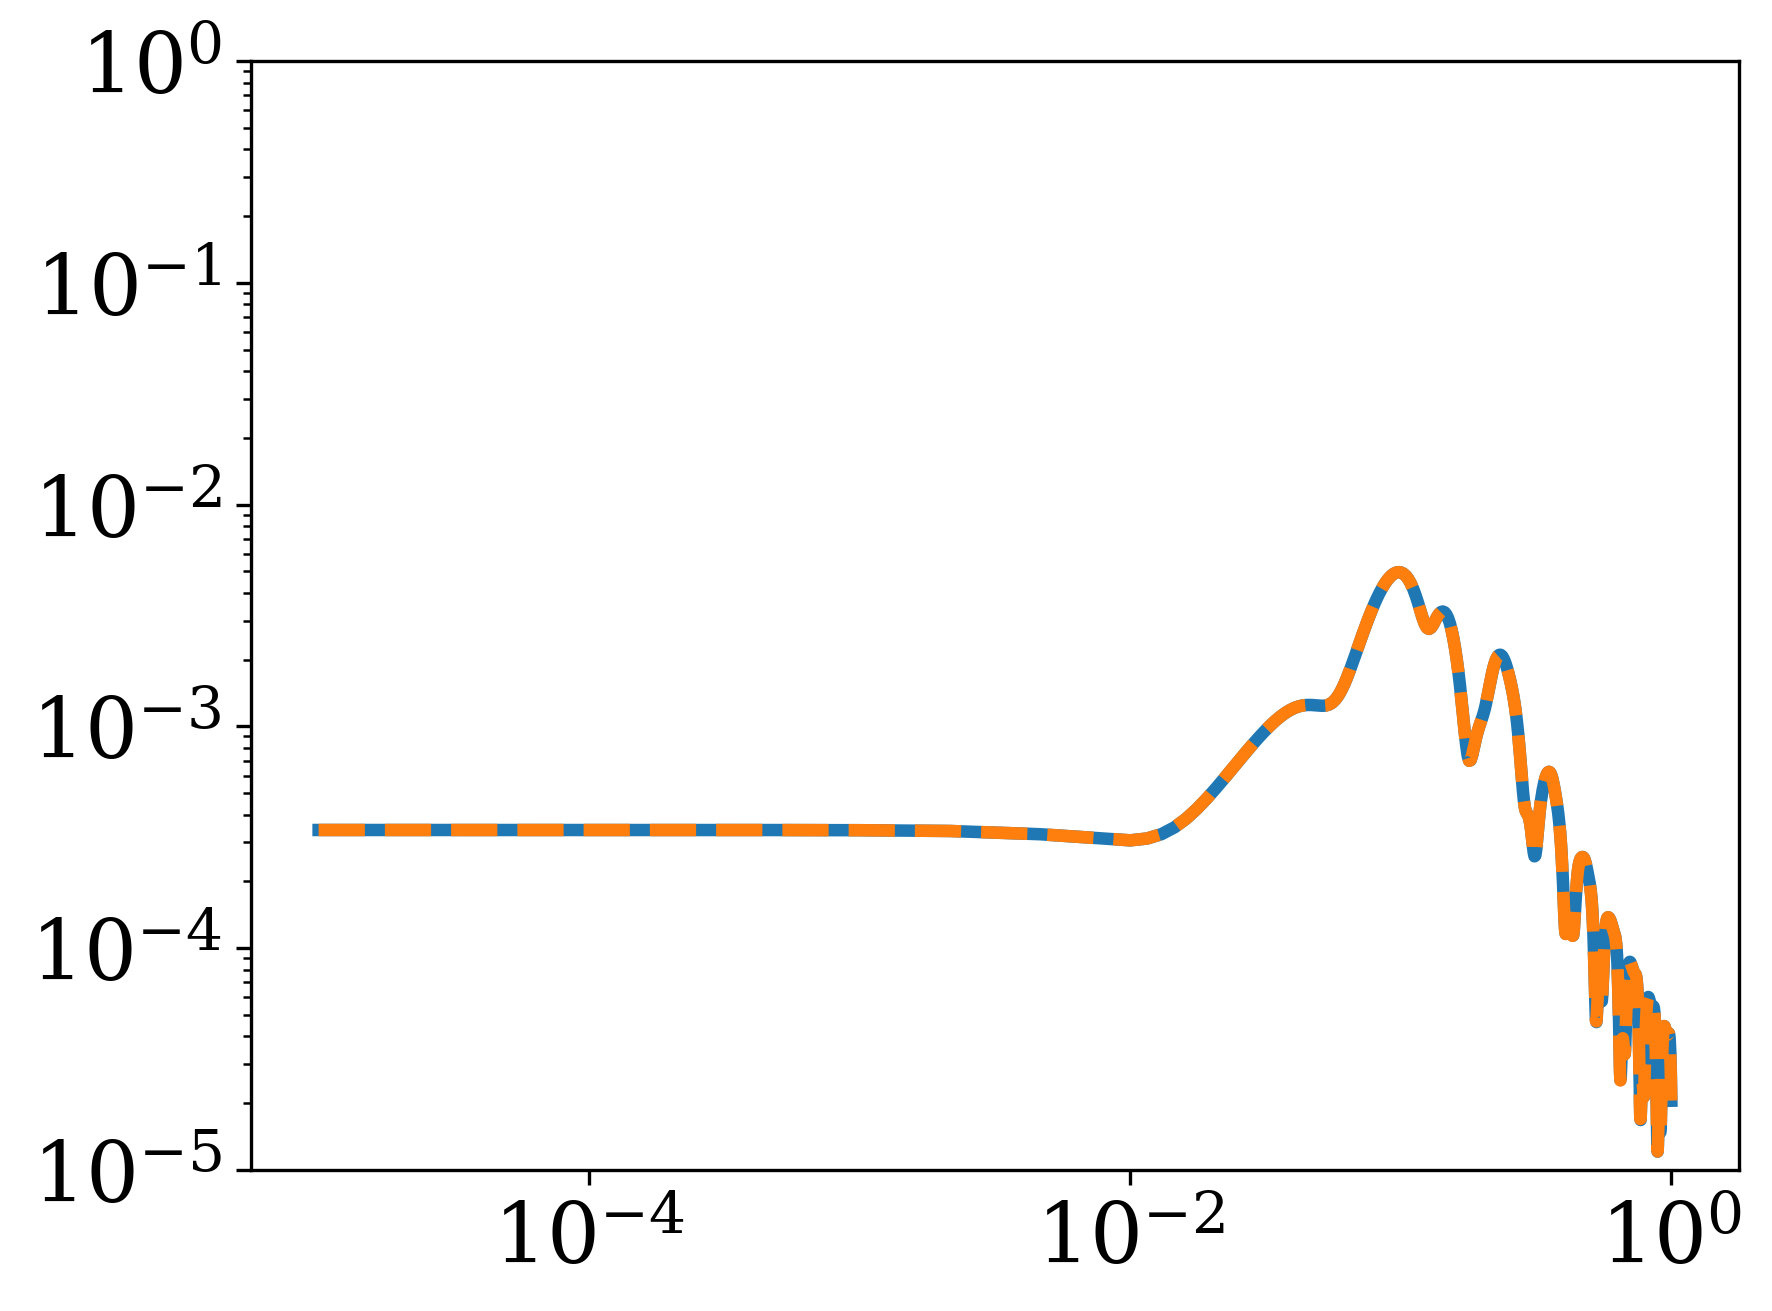

In [26]:
R6_AA = R6[0]

plt.plot(f_vec,R6_AA)
plt.plot(f_vec,LISA_Rell_6_AA, linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-5,1)
